In [1]:
!pip install medmnist --quiet
#!pip install --upgrade tensorflow --quiet
!pip install --upgrade keras_tuner --quiet
#!pip install --upgrade keras --quiet

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import numpy as np
import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner; from keras import layers
keras.utils.set_random_seed(23)

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)
def print_cm(model):
    y_pred = model.predict(X_test).argmax(axis = 1)
    y_true = y_test.argmax(axis = 1)

    disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Blues,
          normalize="true",
      )
    disp.ax_.set_title("Confusion Matrix")
    fig = disp.ax_.get_figure()
    fig.set_figwidth(15)
    fig.set_figheight(15)

    disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Reds,
          normalize="pred",
      )
    disp.ax_.set_title("Confusion Matrix")
    fig = disp.ax_.get_figure()
    fig.set_figwidth(15)
    fig.set_figheight(15)

In [4]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size = 64)
val_dataset = DataClass(split='val', download=download, size = 64)
test_dataset = DataClass(split='test', download=download, size = 64)


train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 361470105/361470105 [07:40<00:00, 784532.12it/s] 


Using downloaded and verified file: C:\Users\Hugo\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\Hugo\.medmnist\organmnist3d_64.npz


In [9]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 64, 64, 64) (971, 1) (610, 64, 64, 64) (610, 1)


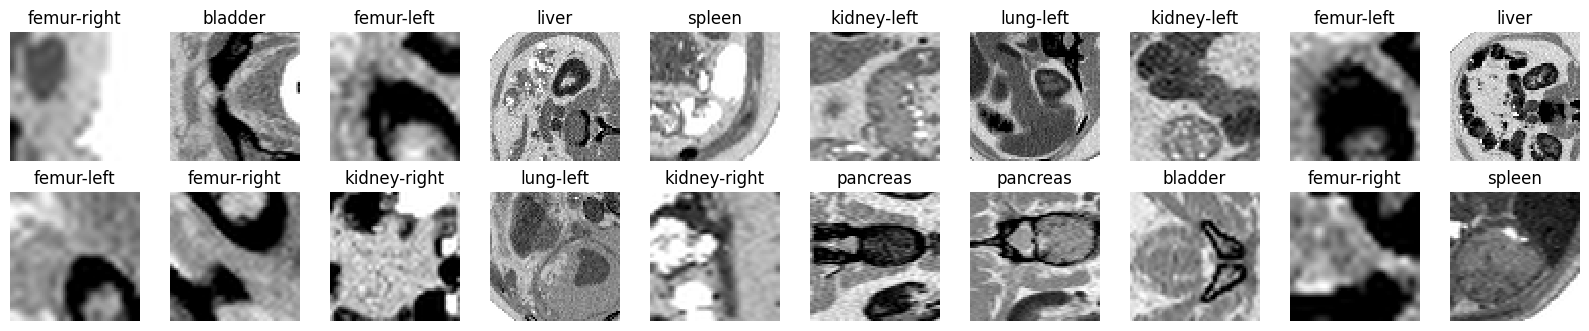

In [10]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
  ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

In [11]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
input_shape = X_train[0].shape
input_shape

(971, 64, 64, 64) (971, 11) (610, 64, 64, 64) (610, 11)


(64, 64, 64)

# DenseNet

In [8]:
"""
Creating a 3D DenseNet 121
Code modified from https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8
"""

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool3D, GlobalAveragePooling3D, MaxPool3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

def densenet3D(input_shape, n_classes, filters=32):
    """
        Creates a tf/keras 3D Densenet121 model
        Args:
            input_shape (tuple): the input shape - width x height x depth x channels
                In our case (80, 64, 16, 1) for the smaller datasets and (160, 128, 32, 1) for the bigger dataset.
            n_classes (int): The number of classes to be predicted.
            filters (int): number of filters, optional
        Returns:
            model (tf.keras.models.Model): The 3D Densenet121 model
    """
    def bn_rl_conv(x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv3D(filters, kernel, strides=strides, padding='same')(x)
        return x
    
    def dense_block(x, repetition):
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool3D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv3D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool3D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        d = dense_block(x, repetition)
        x = transition_layer(d)

    x = GlobalAveragePooling3D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

In [9]:
"""
Creating a 2D DenseNet 121
Code modified from https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8
"""

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

def densenet2D(input_shape, n_classes, filters=32):
    """
        Creates a tf/keras 2D Densenet121 model
        Args:
            input_shape (tuple): the input shape - width x height x depth
                In our case (80, 64, 16) for the smaller datasets and (160, 128, 32) for the bigger dataset.
            n_classes (int): The number of classes to be predicted.
            filters (int): number of filters, optional
        Returns:
            model (tf.keras.models.Model): The 2D Densenet121 model
    """
    def bn_rl_conv(x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        d = dense_block(x, repetition)
        x = transition_layer(d)
        
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

## 2D

In [58]:
filters = 32
class MyHyperModel():
    def bn_rl_conv(self,x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding = 'same')(x)
        return x
    
    def dense_block(self,x, repetition):
        for _ in range(repetition):
            y = self.bn_rl_conv(x, 4*filters)
            y = self.bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(self,x):
        x = self.bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

    def build(self):
        inputs = Input(input_shape)
        x = keras.layers.Rescaling(1./(255/2) -1)(inputs)
        
        x = Conv2D(64, 7, strides = 2, padding = 'same')(x)
        x = MaxPool2D(3, strides = 2, padding = 'same')(x)

        for repetition in [6,12,24,16]:
            d = self.dense_block(x, repetition)
            x = self.transition_layer(d)

        x = GlobalAveragePooling2D()(d)
        outputs = Dense(num_classes, activation = 'softmax')(x)

        model = Model(inputs, outputs)
        opt = keras.optimizers.Adam(learning_rate=0.001619)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return model
    def fit(self, M, x, y, xy_val, **kwargs):
        factor = 0.313359; patience = 10
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
        early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
        #kwargs['callbacks'].extend([reduce_cb, early_cb])
        return M.fit(x, y, batch_size=128, epochs=50, validation_data=xy_val, **kwargs)

In [59]:
M = MyHyperModel()

In [60]:
model = M.build()
M.fit(model,X_train, y_train, (X_val, y_val), verbose=1)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - accuracy: 0.2195 - loss: 3.6255 - val_accuracy: 0.0807 - val_loss: 3984.1567
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.5150 - loss: 1.4121 - val_accuracy: 0.0807 - val_loss: 91548.1328
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.7436 - loss: 0.7681 - val_accuracy: 0.0807 - val_loss: 67461.8359
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.7806 - loss: 0.6424 - val_accuracy: 0.0807 - val_loss: 19972.3125
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8323 - loss: 0.5685 - val_accuracy: 0.0807 - val_loss: 5748.2383
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.8507 - loss: 0.5252 - val_accuracy: 0.0807 - val_loss: 9285.2900
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.8777 - loss: 0.4170 - val_accuracy: 0.0807 - val_loss: 4929.0708
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9203 - loss: 0.2376 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step


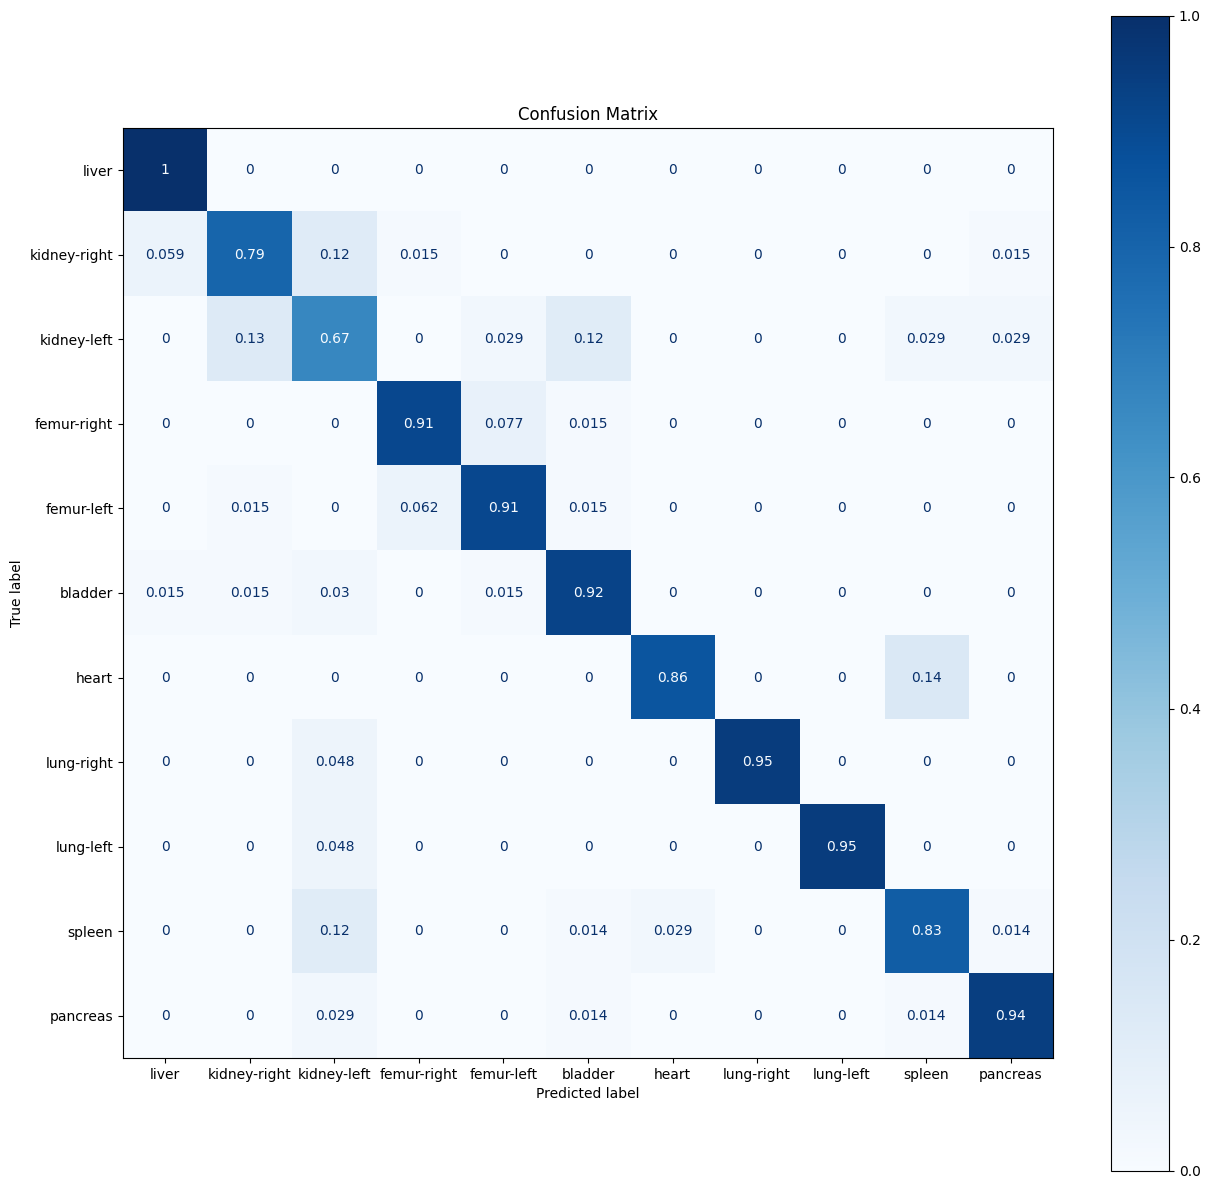

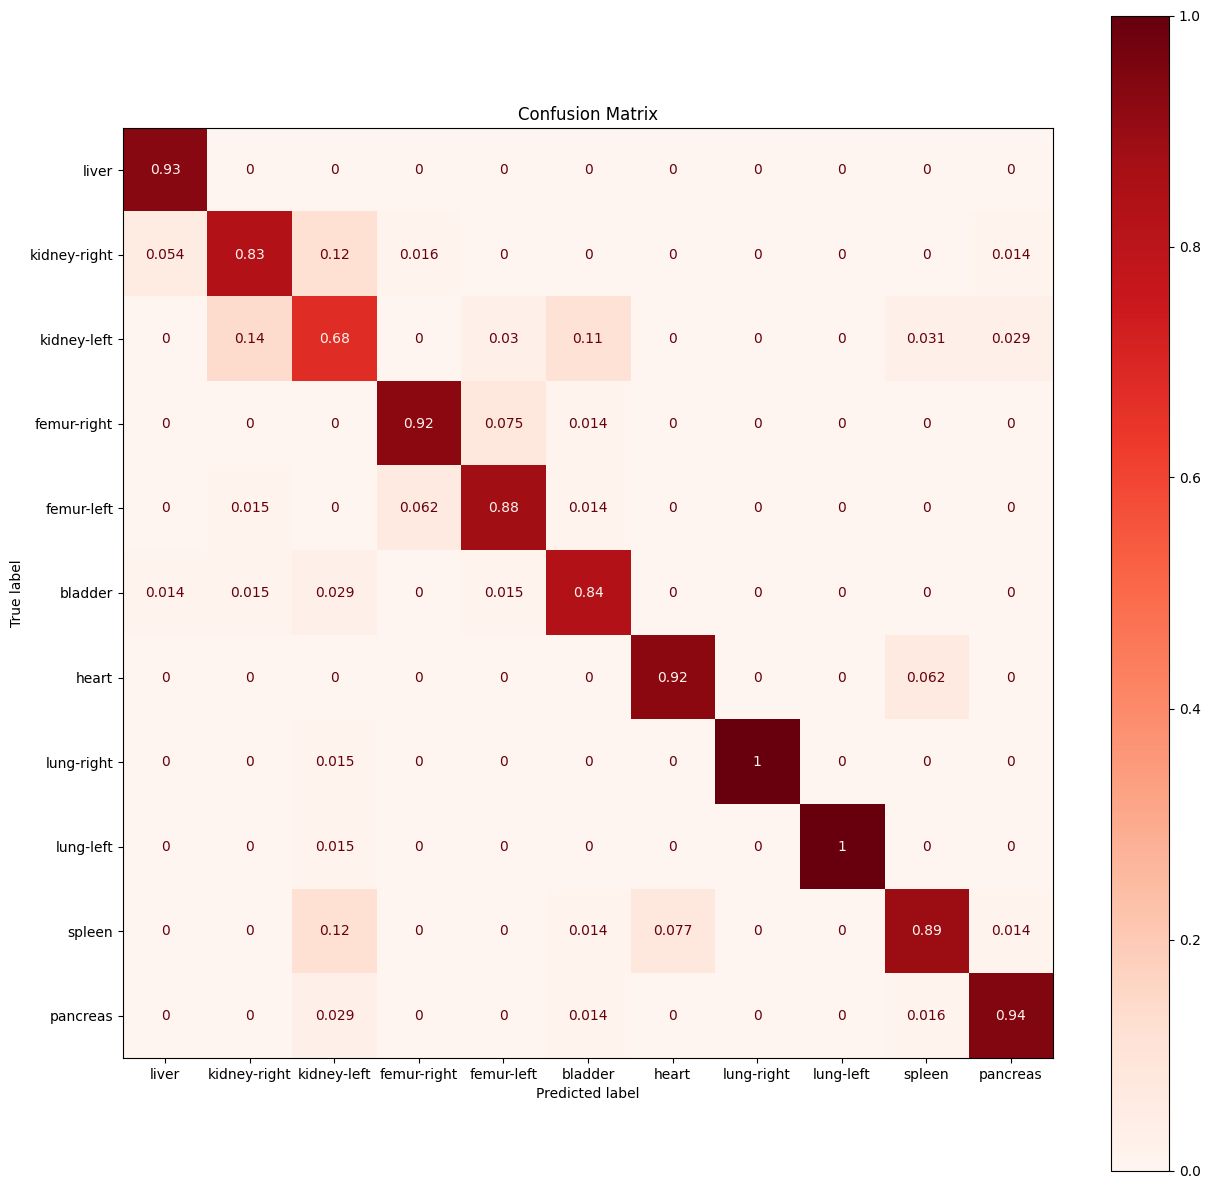

In [61]:
print_cm(model)

In [62]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.7895
Precisión: 87.54%


## 2D with data augmentation

In [12]:
filters = 32
class MyHyperModel():
    def bn_rl_conv(self,x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding = 'same')(x)
        return x
    
    def dense_block(self,x, repetition):
        for _ in range(repetition):
            y = self.bn_rl_conv(x, 4*filters)
            y = self.bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(self,x):
        x = self.bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

    def build(self):
        inputs = Input(input_shape)
        factor = 0.2
        inputs = keras.layers.RandomRotation(factor, fill_mode="nearest")(inputs)
        inputs = keras.layers.RandomTranslation(factor, factor, fill_mode="nearest")(inputs)
        inputs = keras.layers.RandomZoom(factor, fill_mode="nearest")(inputs)
        x = keras.layers.Rescaling(1./(255/2) -1)(inputs)
        
        x = Conv2D(64, 7, strides = 2, padding = 'same')(x)
        x = MaxPool2D(3, strides = 2, padding = 'same')(x)

        for repetition in [6,12,24,16]:
            d = self.dense_block(x, repetition)
            x = self.transition_layer(d)

        x = GlobalAveragePooling2D()(d)
        outputs = Dense(num_classes, activation = 'softmax')(x)

        model = Model(inputs, outputs)
        opt = keras.optimizers.Adam(learning_rate=0.001619)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return model
    def fit(self, M, x, y, xy_val, **kwargs):
        factor = 0.313359; patience = 10
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
        early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
        #kwargs['callbacks'] = [reduce_cb]
        return M.fit(x, y, batch_size=128, epochs=70, validation_data=xy_val, **kwargs)

Epoch 1/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 189s 9s/step - accuracy: 0.2186 - loss: 3.4322 - val_accuracy: 0.0807 - val_loss: 13791.2822
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5588 - loss: 2.1812 - val_accuracy: 0.0807 - val_loss: 121882.6719
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.7323 - loss: 0.8265 - val_accuracy: 0.0807 - val_loss: 181419.6562
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.7949 - loss: 0.6047 - val_accuracy: 0.0807 - val_loss: 204024.8125
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.8530 - loss: 0.4579 - val_accuracy: 0.0807 - val_loss: 78242.0625
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.8913 - loss: 0.3233 - val_accuracy: 0.0807 - val_loss: 24132.4395
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.9230 - loss: 0.2511 - val_accuracy: 0.0807 - val_loss: 23004.3633
Epoch 8/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.9073 - loss: 0.2354 - va

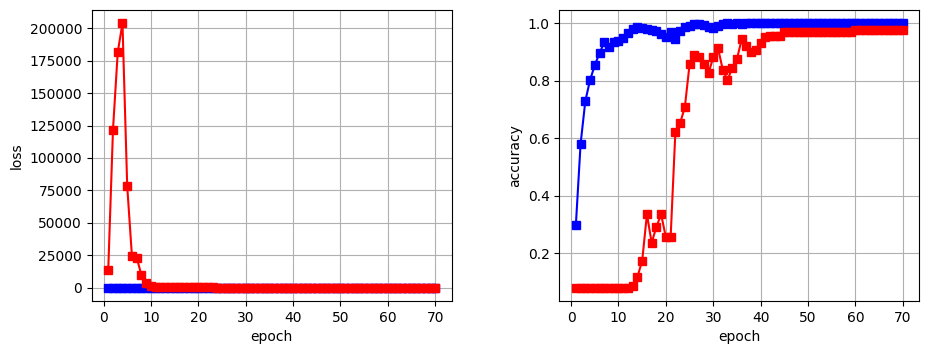

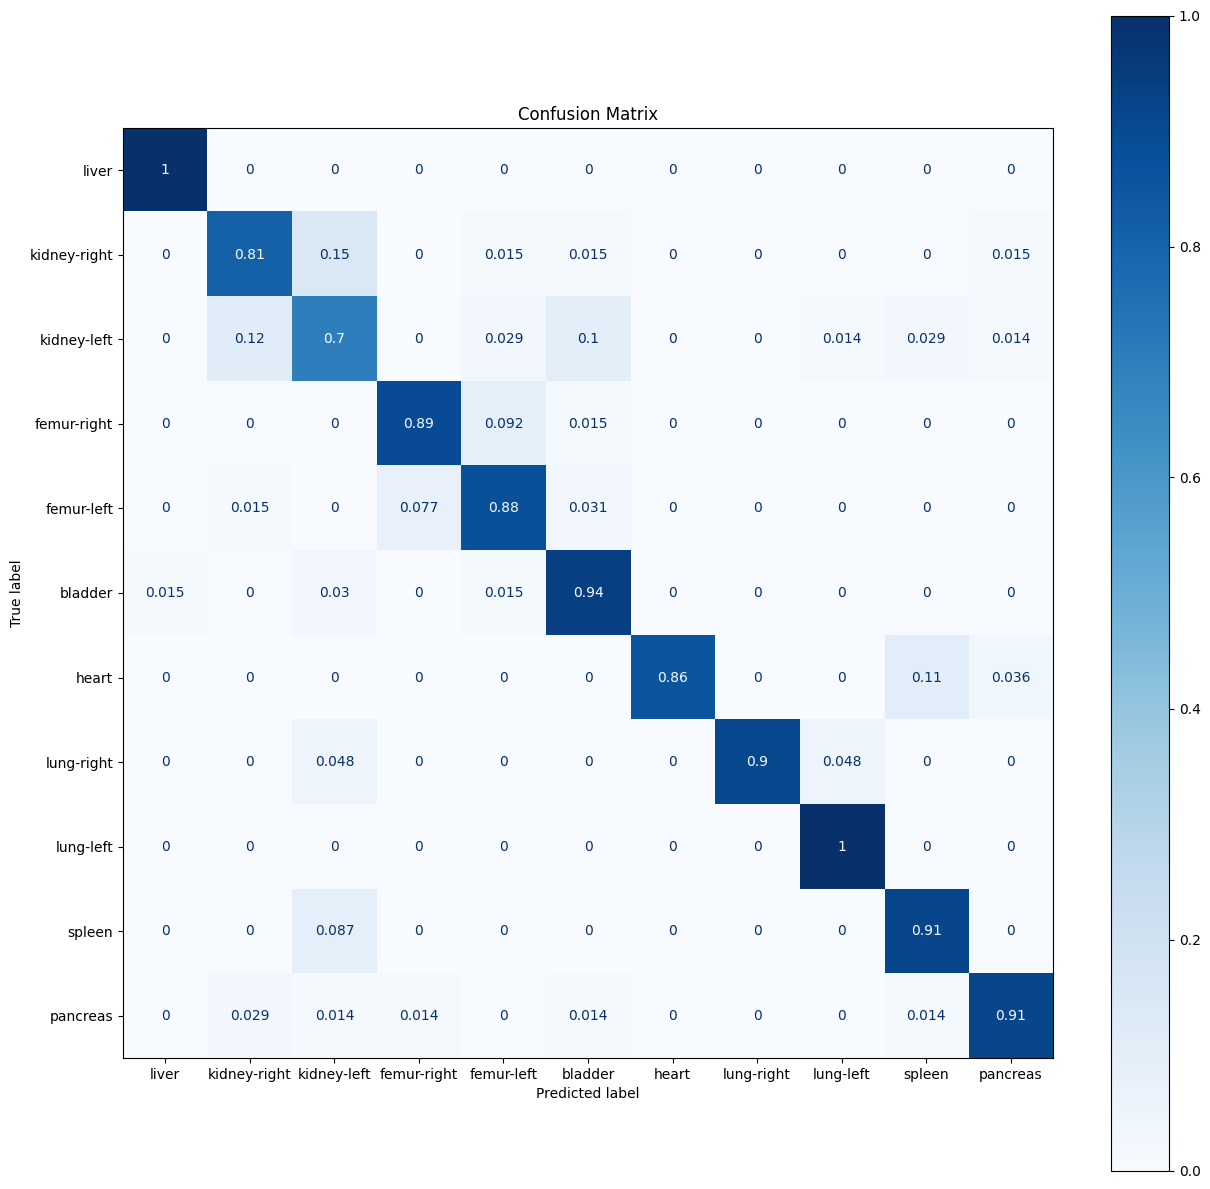

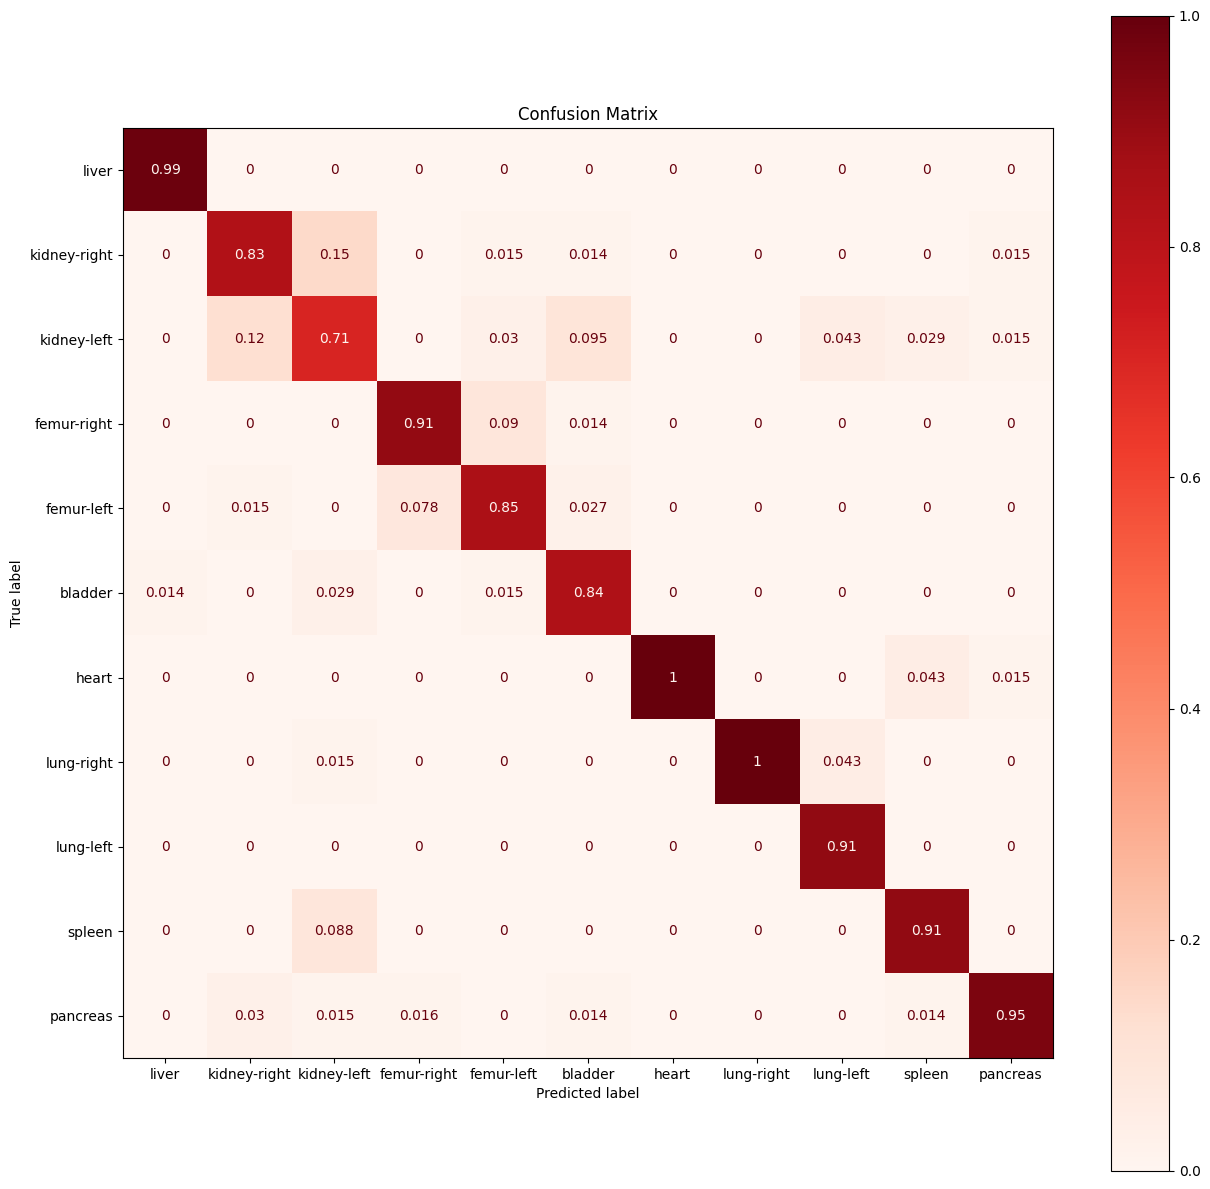

In [13]:
M = MyHyperModel()
model = M.build()
H = M.fit(model,X_train, y_train, (X_val, y_val), verbose=1)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

print_cm(model)

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

## 3D 

Using downloaded and verified file: C:\Users\Hugo\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\Hugo\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\Hugo\.medmnist\organmnist3d_64.npz
(971, 64, 64, 64) (971, 1) (610, 64, 64, 64) (610, 1)
(971, 64, 64, 64) (971, 11) (610, 64, 64, 64) (610, 11)


(64, 64, 64)

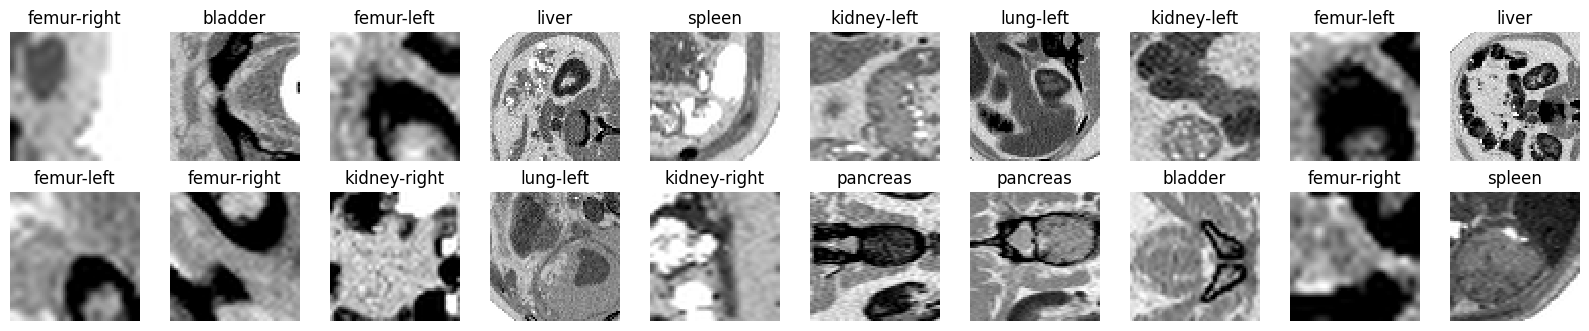

In [8]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size = 64)
val_dataset = DataClass(split='val', download=download, size = 64)
test_dataset = DataClass(split='test', download=download, size = 64)

import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    
    
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
input_shape = X_train[0].shape
input_shape

In [11]:
filters = 32
class MyHyperModel():
    def bn_rl_conv(self,x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv3D(filters, kernel, strides=strides, padding = 'same')(x)
        return x
    
    def dense_block(self,x, repetition):
        for _ in range(repetition):
            y = self.bn_rl_conv(x, 4*filters)
            y = self.bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(self,x):
        x = self.bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool3D(2, strides = 2, padding = 'same')(x)
        return x

    def build(self):
        inputs = Input(input_shape)
        factor = 0.2
        inputs = keras.layers.RandomRotation(factor, fill_mode="nearest")(inputs)
        inputs = keras.layers.RandomTranslation(factor, factor, fill_mode="nearest")(inputs)
        inputs = keras.layers.RandomZoom(factor, fill_mode="nearest")(inputs)
        x = keras.layers.Rescaling(1./(255/2) -1)(inputs)
        x = tf.expand_dims(x, axis=-1)
        
        x = Conv3D(64, 7, strides = 2, padding = 'same')(x)
        x = MaxPool3D(3, strides = 2, padding = 'same')(x)

        for repetition in [6,12,24,16]:
            d = self.dense_block(x, repetition)
            x = self.transition_layer(d)

        x = GlobalAveragePooling3D()(d)
        outputs = Dense(num_classes, activation = 'softmax')(x)

        model = Model(inputs, outputs)
        opt = keras.optimizers.Adam(learning_rate=0.001619)
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return model
    def fit(self, M, x, y, xy_val, **kwargs):
        factor = 0.313359; patience = 10
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
        early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
        #kwargs['callbacks'] = [reduce_cb]
        return M.fit(x, y, batch_size=128, epochs=70, validation_data=xy_val, **kwargs)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool3D, GlobalAveragePooling3D, MaxPool3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [ ]:
M = MyHyperModel()
model = M.build()
H = M.fit(model,X_train, y_train, (X_val, y_val), verbose=1)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

print_cm(model)

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Epoch 1/70
8/8 [==============================] - 1296s 155s/step - loss: 3.8029 - accuracy: 0.2575 - val_loss: 39703220.0000 - val_accuracy: 0.0807
Epoch 2/70
8/8 [==============================] - 1226s 153s/step - loss: 1.4861 - accuracy: 0.4624 - val_loss: 766777536.0000 - val_accuracy: 0.0807
Epoch 3/70
3/8 [==========>...................] - ETA: 11:19 - loss: 0.9789 - accuracy: 0.6146

# ViVit

## Zero-shot

In [22]:
# Note: 'keras<3.x' or 'tf_keras' must be installed (legacy)
# See https://github.com/keras-team/tf-keras for more details.
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/video-vision-transformer")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/8.35k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/147k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/6.72M [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

100%|██████████| 32657349/32657349 [00:01<00:00, 16710928.20it/s]


Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
(971, 28, 28, 28) (971, 1) (610, 28, 28, 28) (610, 1)
(971, 28, 28, 28, 1) (971, 11) (610, 28, 28, 28, 1) (610, 11)


(28, 28, 28, 1)

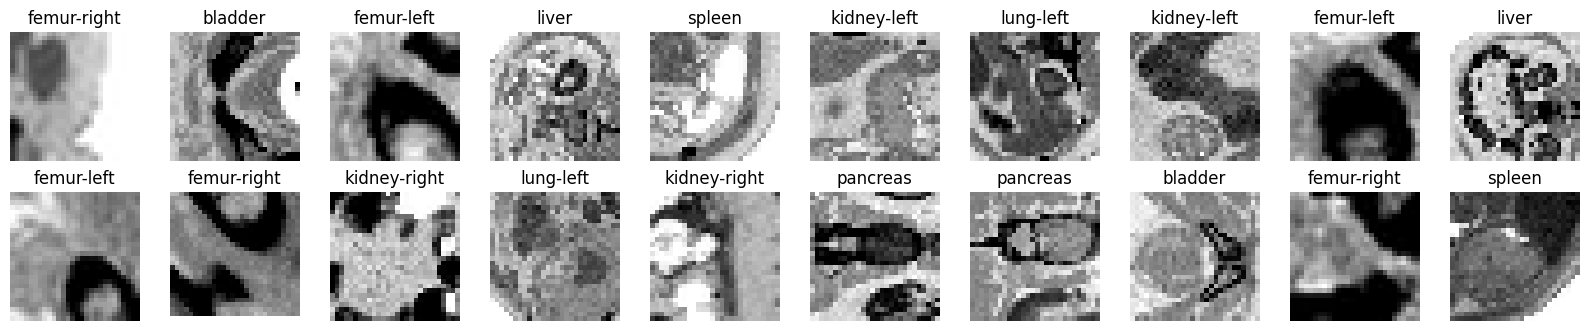

In [23]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    
    
import numpy as np

x, y = train_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
input_shape = X_train[0].shape
input_shape

20/20 [==============================] - 5s 16ms/step
Loss: 0.9412
Precisión: 79.67%


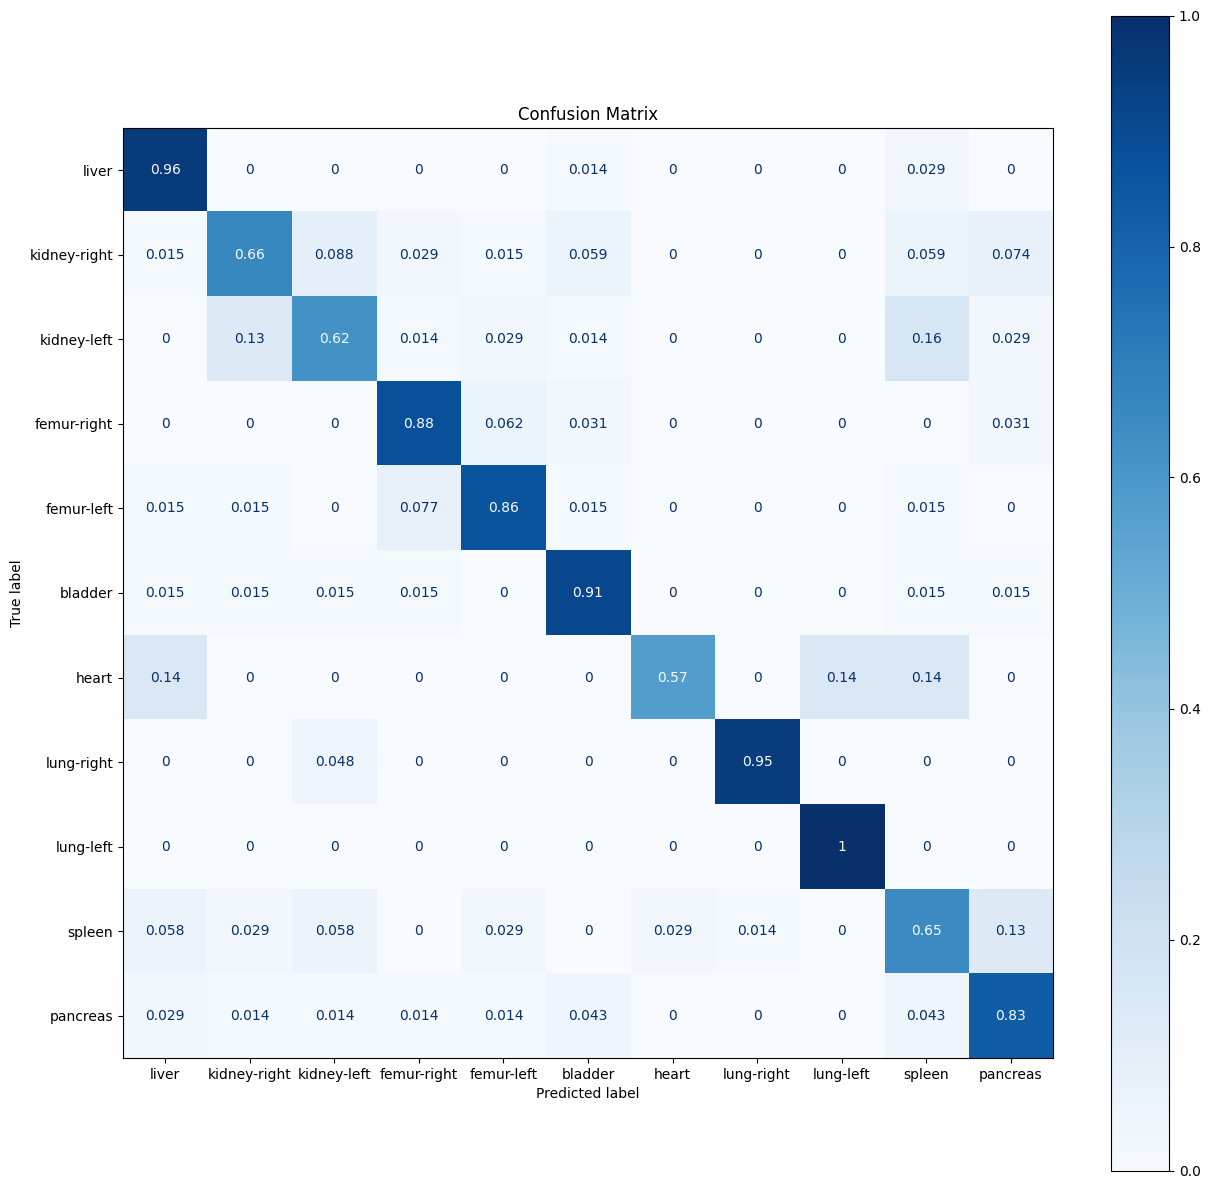

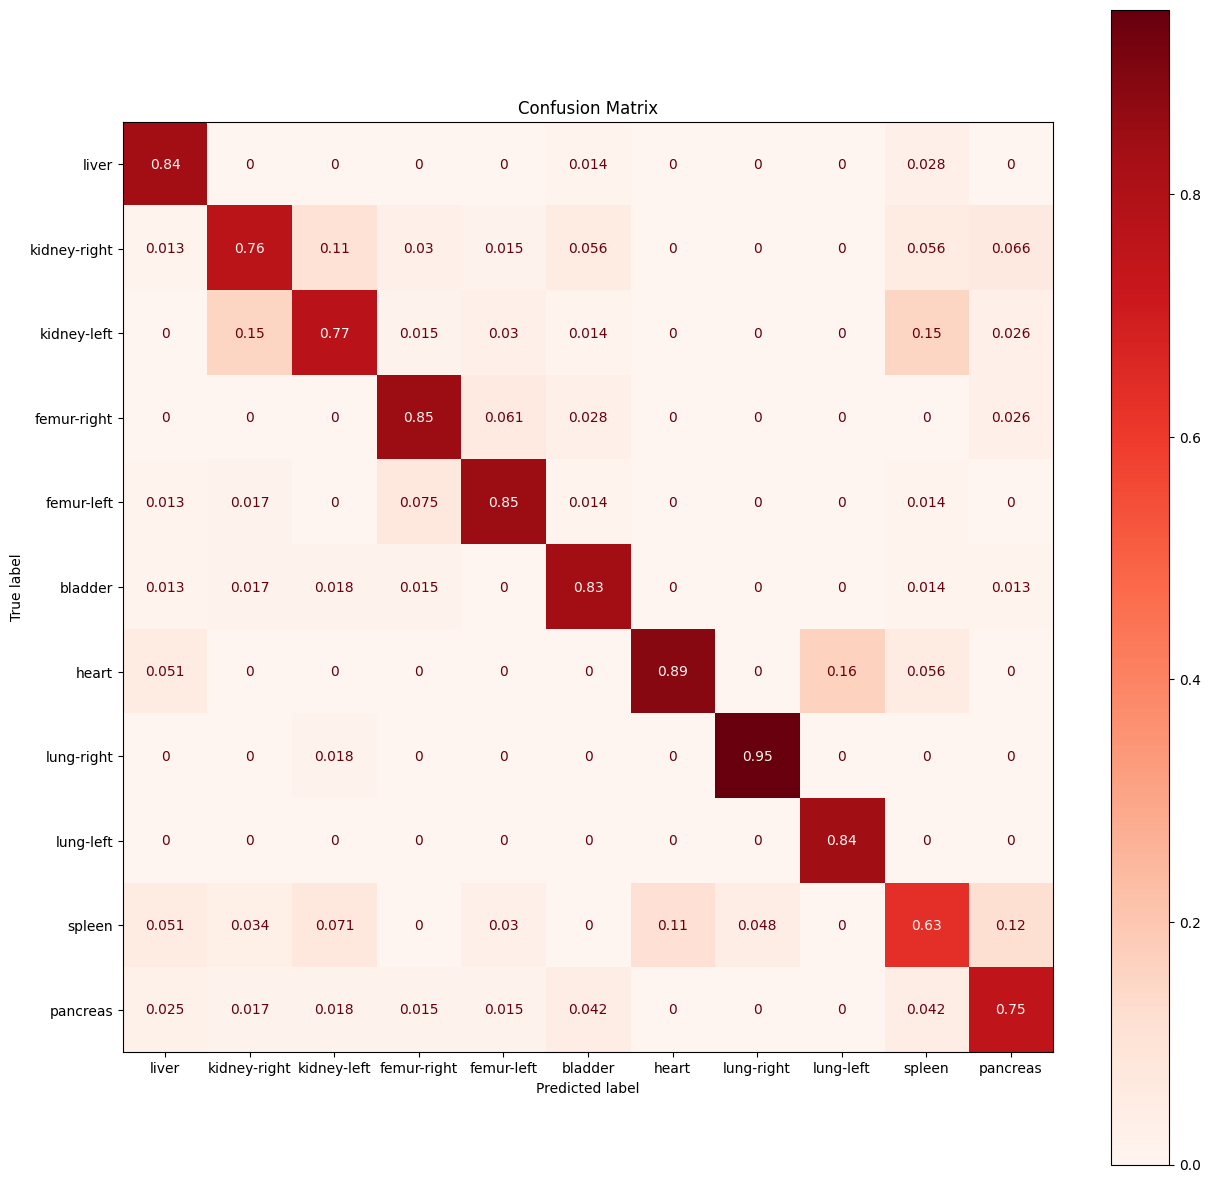

In [25]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print_cm(model)

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

## Fine-tuning

In [30]:
# Note: 'keras<3.x' or 'tf_keras' must be installed (legacy)
# See https://github.com/keras-team/tf-keras for more details.
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/video-vision-transformer")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 32657349/32657349 [00:01<00:00, 16570134.91it/s]


Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
(971, 28, 28, 28) (971, 1) (610, 28, 28, 28) (610, 1)
(971, 28, 28, 28, 1) (971, 11) (610, 28, 28, 28, 1) (610, 11)


(28, 28, 28, 1)

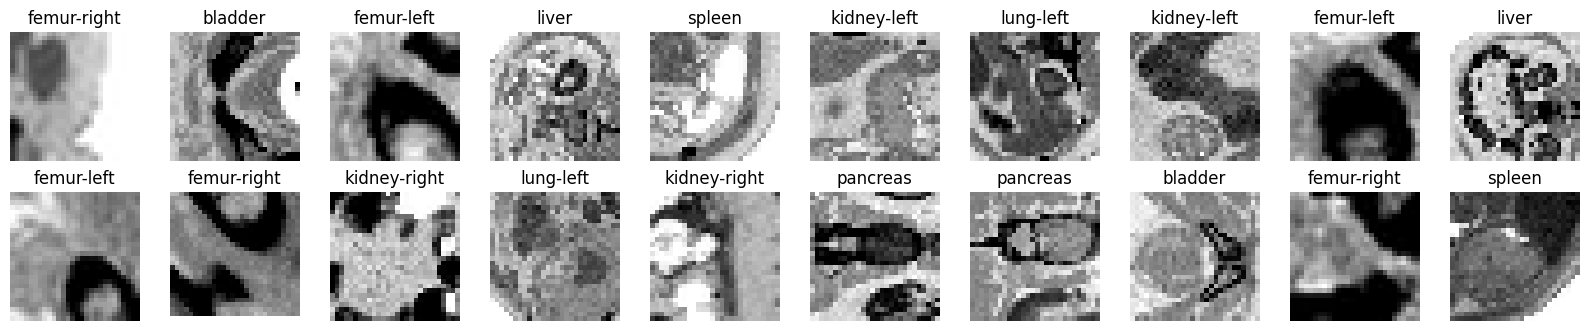

In [35]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    
    
import numpy as np

x, y = train_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
input_shape = X_train[0].shape
input_shape


In [26]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

factor = 0.313359; patience = 10
kwargs = {}
reduce_cb = ReduceLROnPlateau(
        monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-7)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
kwargs['callbacks'] = [reduce_cb]

In [38]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
H = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val), **kwargs)

Epoch 1/100
8/8 [==============================] - 37s 783ms/step - loss: 4.3291 - accuracy: 0.2338 - val_loss: 3.3223 - val_accuracy: 0.0994 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 68ms/step - loss: 2.7738 - accuracy: 0.1092 - val_loss: 2.4510 - val_accuracy: 0.0932 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 65ms/step - loss: 2.3859 - accuracy: 0.1195 - val_loss: 2.4805 - val_accuracy: 0.1180 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 62ms/step - loss: 2.3322 - accuracy: 0.0989 - val_loss: 2.3967 - val_accuracy: 0.0994 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 65ms/step - loss: 2.2946 - accuracy: 0.1205 - val_loss: 2.3295 - val_accuracy: 0.1553 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 61ms/step - loss: 2.2682 - accuracy: 0.1658 - val_loss: 2.3566 - val_accuracy: 0.1863 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 62ms/step - loss: 2.2531 -

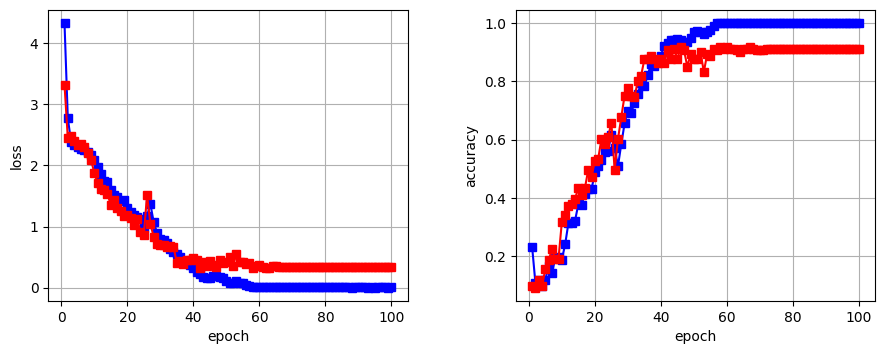

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

20/20 [==============================] - 5s 16ms/step
Loss: 1.179
Precisión: 75.90%


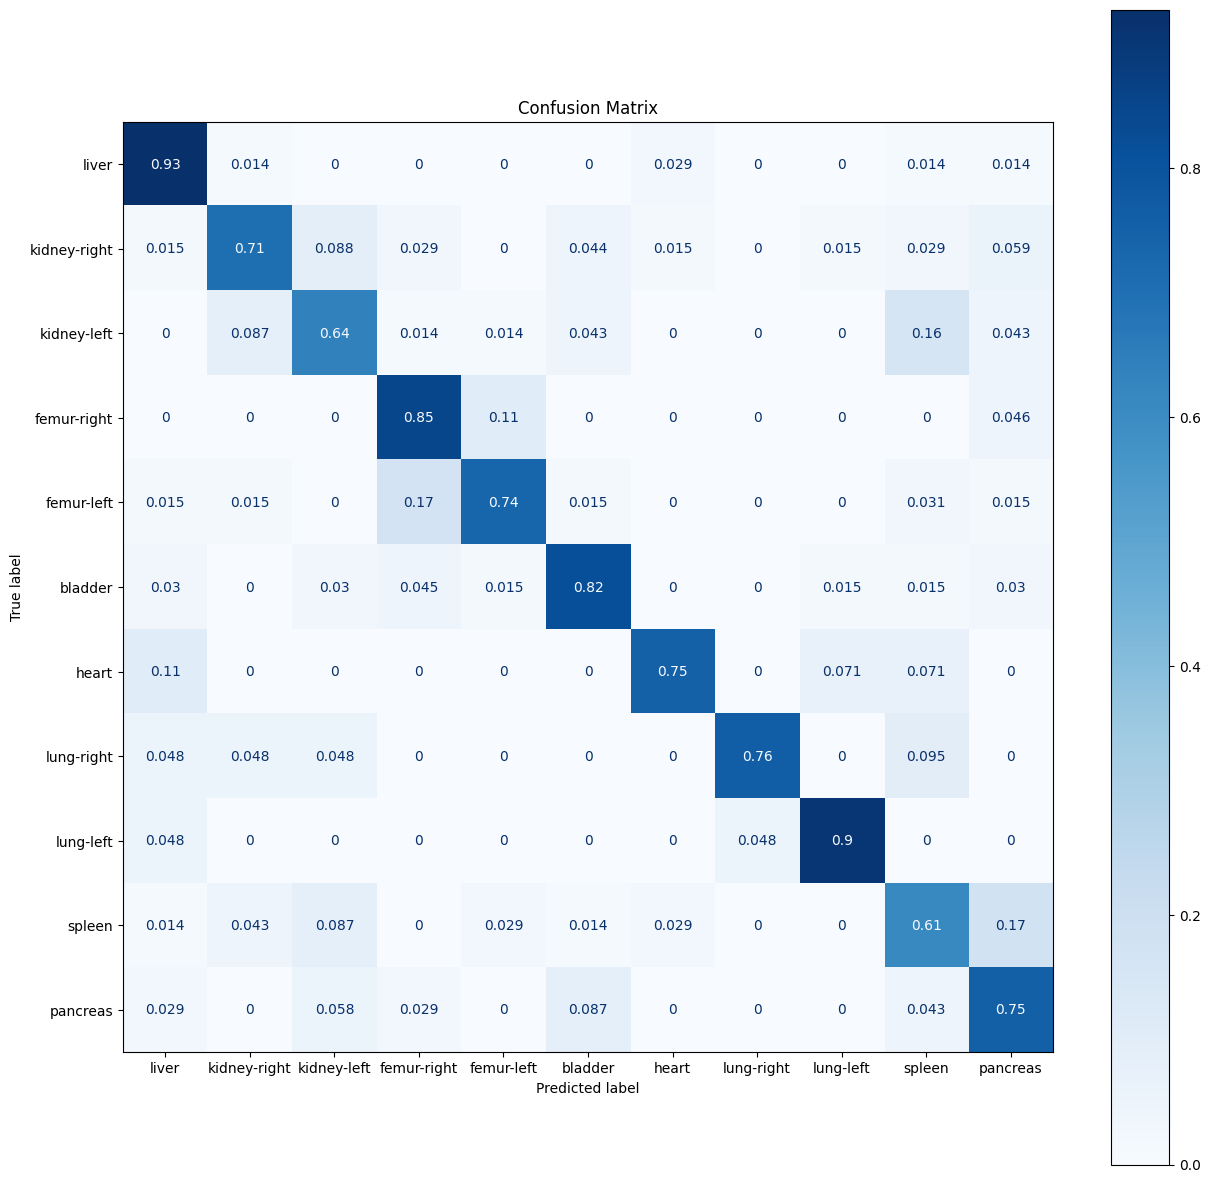

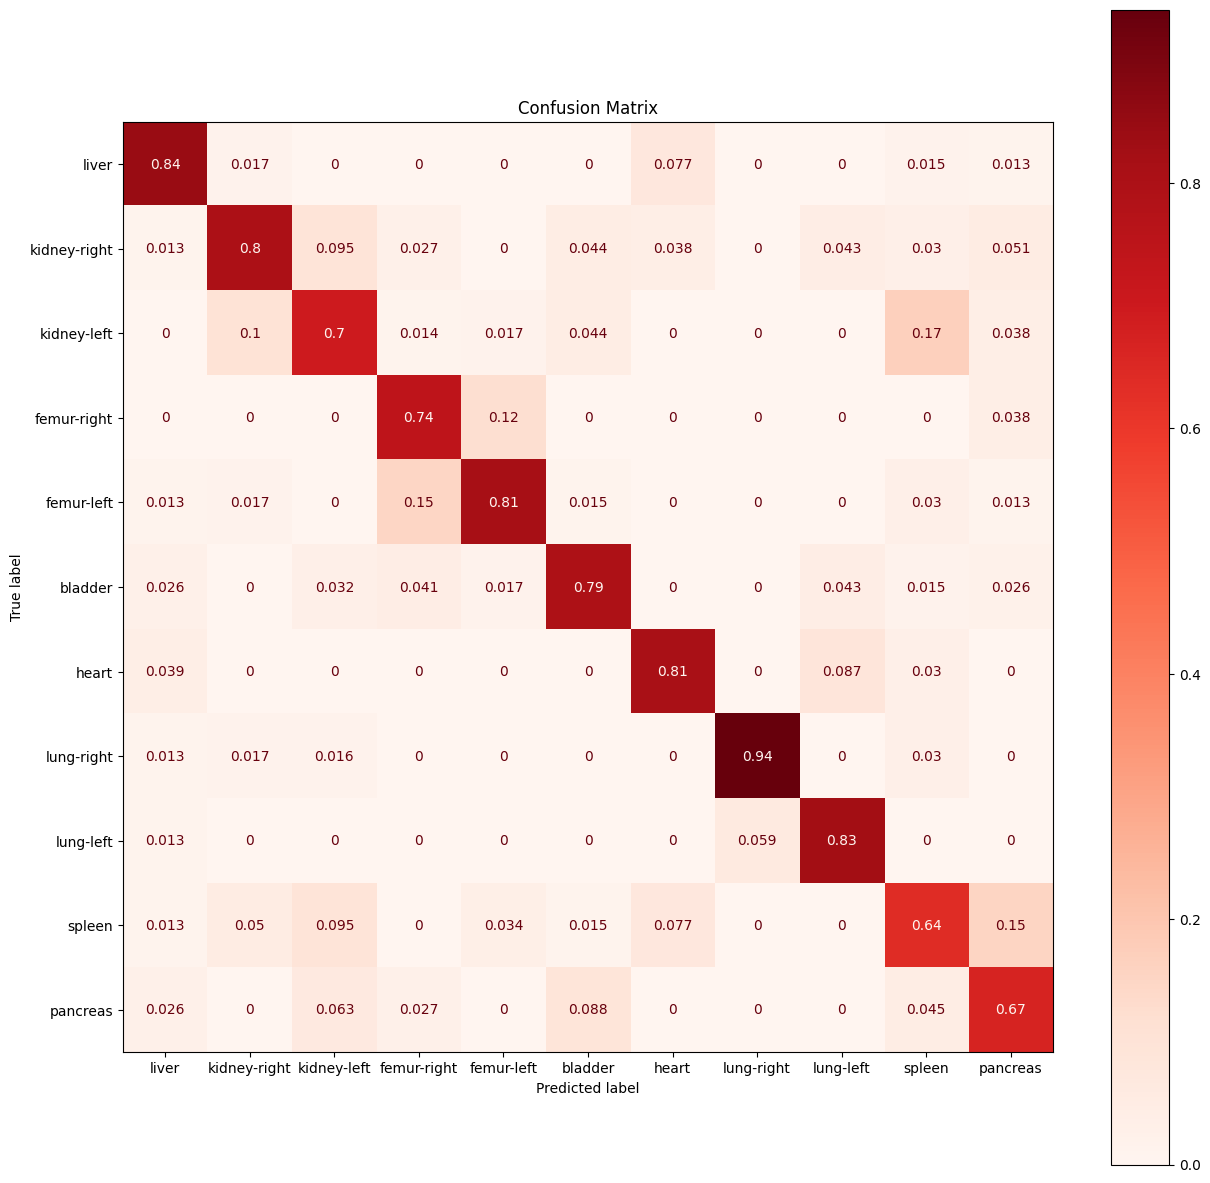

In [33]:
print_cm(model)

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

## Data Augmentation

In [36]:
!pip install volumentations-3D --quiet
from volumentations import *

def get_augmentation():
    return Compose([Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
                    ElasticTransform((0, 0.25), interpolation=2, p=0.1),
                    RandomRotate90((1, 2), p=0.5)], p=1.0)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [37]:
def augmentor(img):
    aug = get_augmentation()
    data = {'image': img}
    aug_data = aug(**data)
    img     = aug_data['image']
    return np.ndarray.astype(img , np.float32)

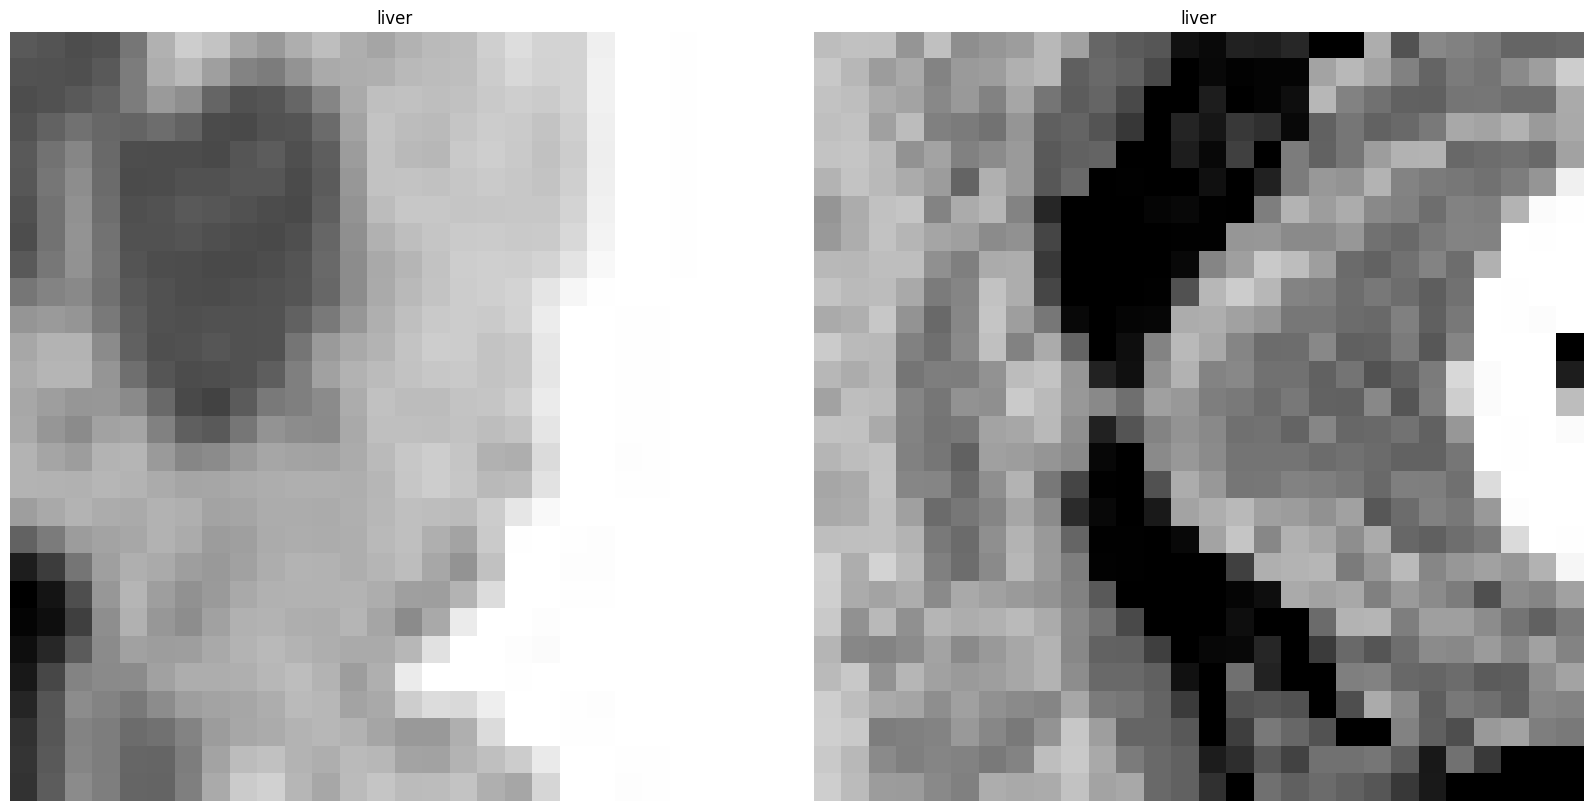

In [38]:
import matplotlib.pyplot as plt
nrows = 1; ncols = 2
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[int(y[0])])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

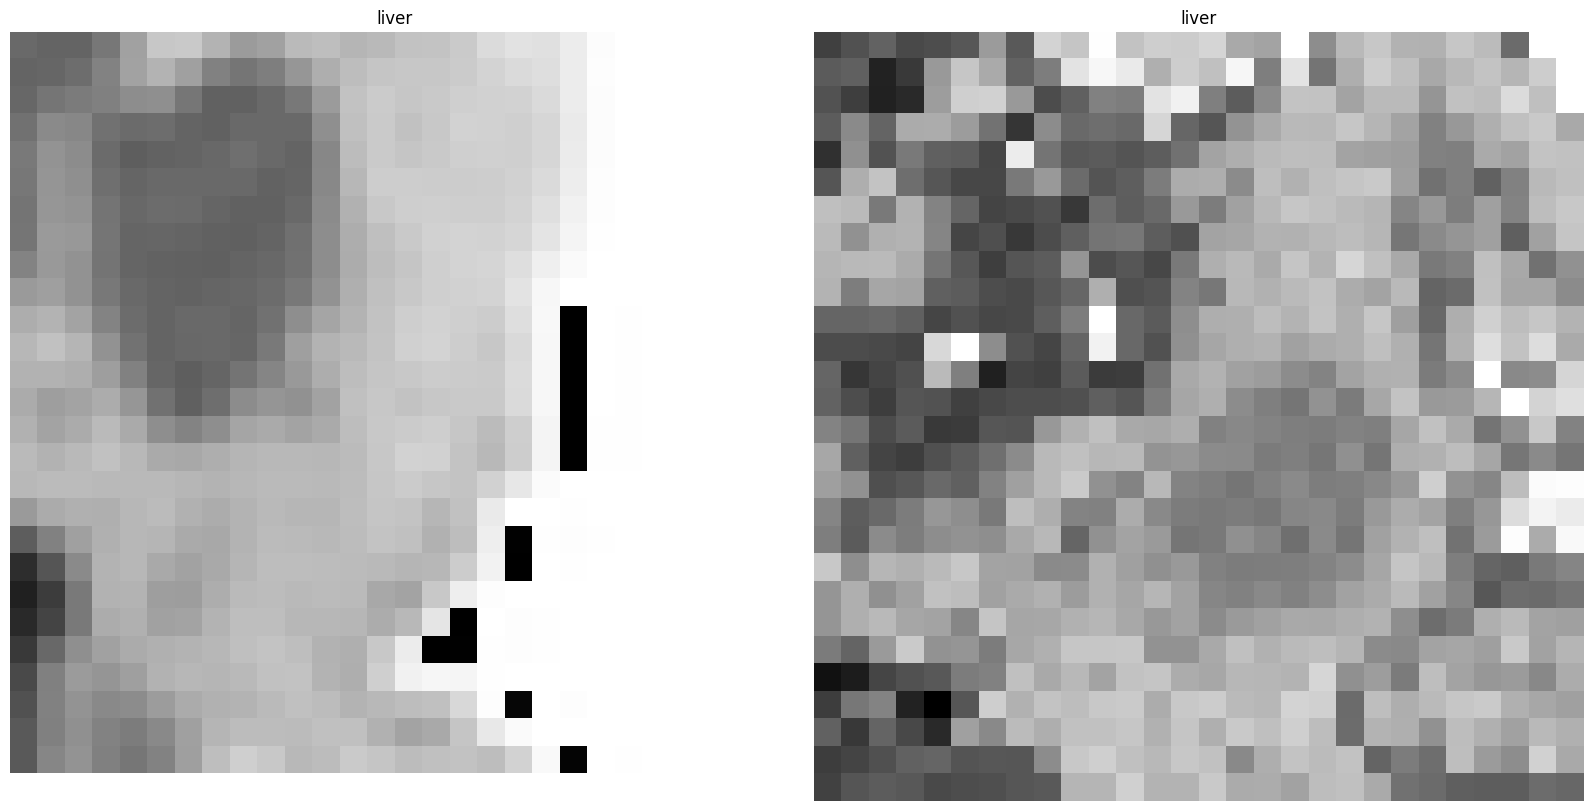

In [39]:
X_aux = np.array([augmentor(X_train[0]), augmentor(X_train[1])])
y_aux = y_train[:2]
import matplotlib.pyplot as plt
nrows = 1; ncols = 2
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_aux, y_aux):
    ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[int(y[0])])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

In [40]:
import pandas as pd

s = pd.Series(y_train.argmax(axis = -1))
X_augmented = X_train
y_augmented = y_train
while min(s.value_counts()) != max(s.value_counts()):
    aux = s[s==s.value_counts()[s.value_counts() == min(s.value_counts())].index[0]]
    idx = aux.index[random.randint(0, len(aux)-1)]
    x, y = augmentor(X_augmented[idx]), y_augmented[idx]
    X_augmented = np.concatenate((X_augmented, np.array([x])), axis = 0)
    y_augmented = np.concatenate((y_augmented, np.array([y])), axis = 0)
    s = pd.Series(y_augmented.argmax(axis = -1))
    print(min(s.value_counts()), end = "\r")

In [41]:
for _ in tqdm(range(5)):
    X_augmented = np.concatenate((X_augmented, X_train), axis = 0)
    y_augmented = np.concatenate((y_augmented, y_train), axis = 0)
    s = pd.Series(y_augmented.argmax(axis = -1))
    while min(s.value_counts()) != max(s.value_counts()):
        aux = s[s==s.value_counts()[s.value_counts() == min(s.value_counts())].index[0]]
        idx = aux.index[random.randint(0, len(aux)-1)]
        x, y = augmentor(X_augmented[idx]), y_augmented[idx]
        X_augmented = np.concatenate((X_augmented, np.array([x])), axis = 0)
        y_augmented = np.concatenate((y_augmented, np.array([y])), axis = 0)
        s = pd.Series(y_augmented.argmax(axis = -1))
        print(min(s.value_counts()), end = "\r")

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:22<01:31, 22.77s/it]

 40%|████      | 2/5 [00:56<01:28, 29.37s/it]

 80%|████████  | 4/5 [02:38<00:44, 44.55s/it]

100%|██████████| 5/5 [03:46<00:00, 45.27s/it]

In [54]:
# Note: 'keras<3.x' or 'tf_keras' must be installed (legacy)
# See https://github.com/keras-team/tf-keras for more details.
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/video-vision-transformer")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [43]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

factor = 0.313359; patience = 10
kwargs = {}
reduce_cb = ReduceLROnPlateau(
        monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-7)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
kwargs['callbacks'] = [reduce_cb]

In [55]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
H = model.fit(X_augmented, y_augmented, batch_size=128, epochs=25, validation_data=(X_val, y_val), **kwargs)

Epoch 1/25
60/60 [==============================] - 38s 135ms/step - loss: 2.3312 - accuracy: 0.2354 - val_loss: 1.8021 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 2/25
60/60 [==============================] - 3s 51ms/step - loss: 1.4139 - accuracy: 0.4640 - val_loss: 1.2044 - val_accuracy: 0.4907 - lr: 0.0010
Epoch 3/25
60/60 [==============================] - 3s 50ms/step - loss: 1.0285 - accuracy: 0.6144 - val_loss: 1.2286 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 4/25
60/60 [==============================] - 3s 51ms/step - loss: 0.7289 - accuracy: 0.7327 - val_loss: 0.6690 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 5/25
60/60 [==============================] - 3s 51ms/step - loss: 0.4741 - accuracy: 0.8307 - val_loss: 0.4927 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 6/25
60/60 [==============================] - 3s 50ms/step - loss: 0.2552 - accuracy: 0.9088 - val_loss: 0.4007 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 7/25
60/60 [==============================] - 3s 51ms/step - loss: 0

20/20 [==============================] - 5s 16ms/step
Loss: 1.256
Precisión: 78.36%


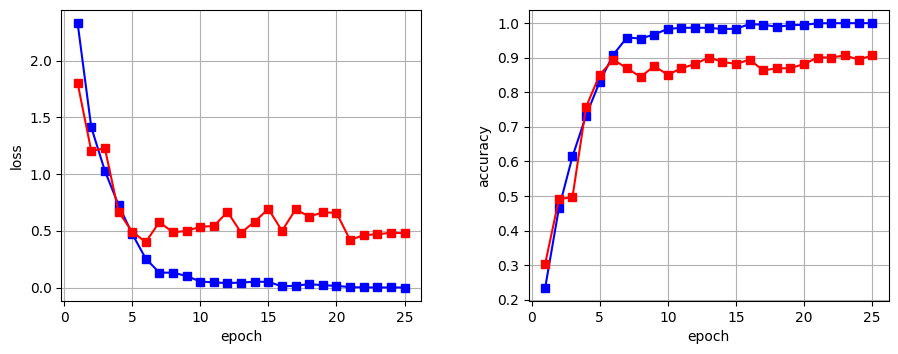

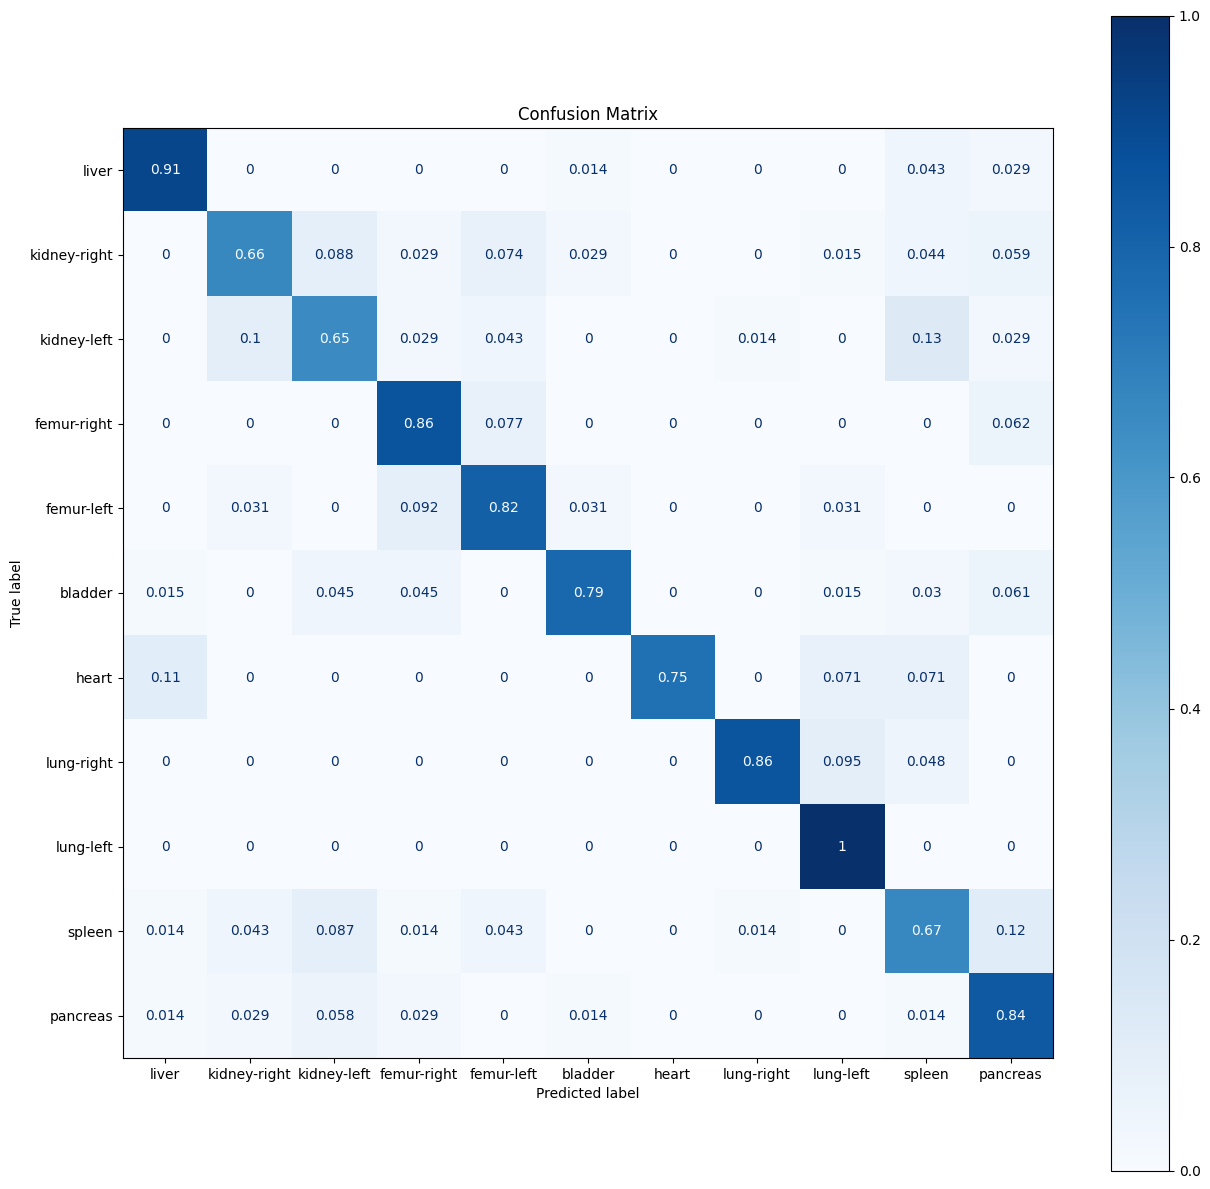

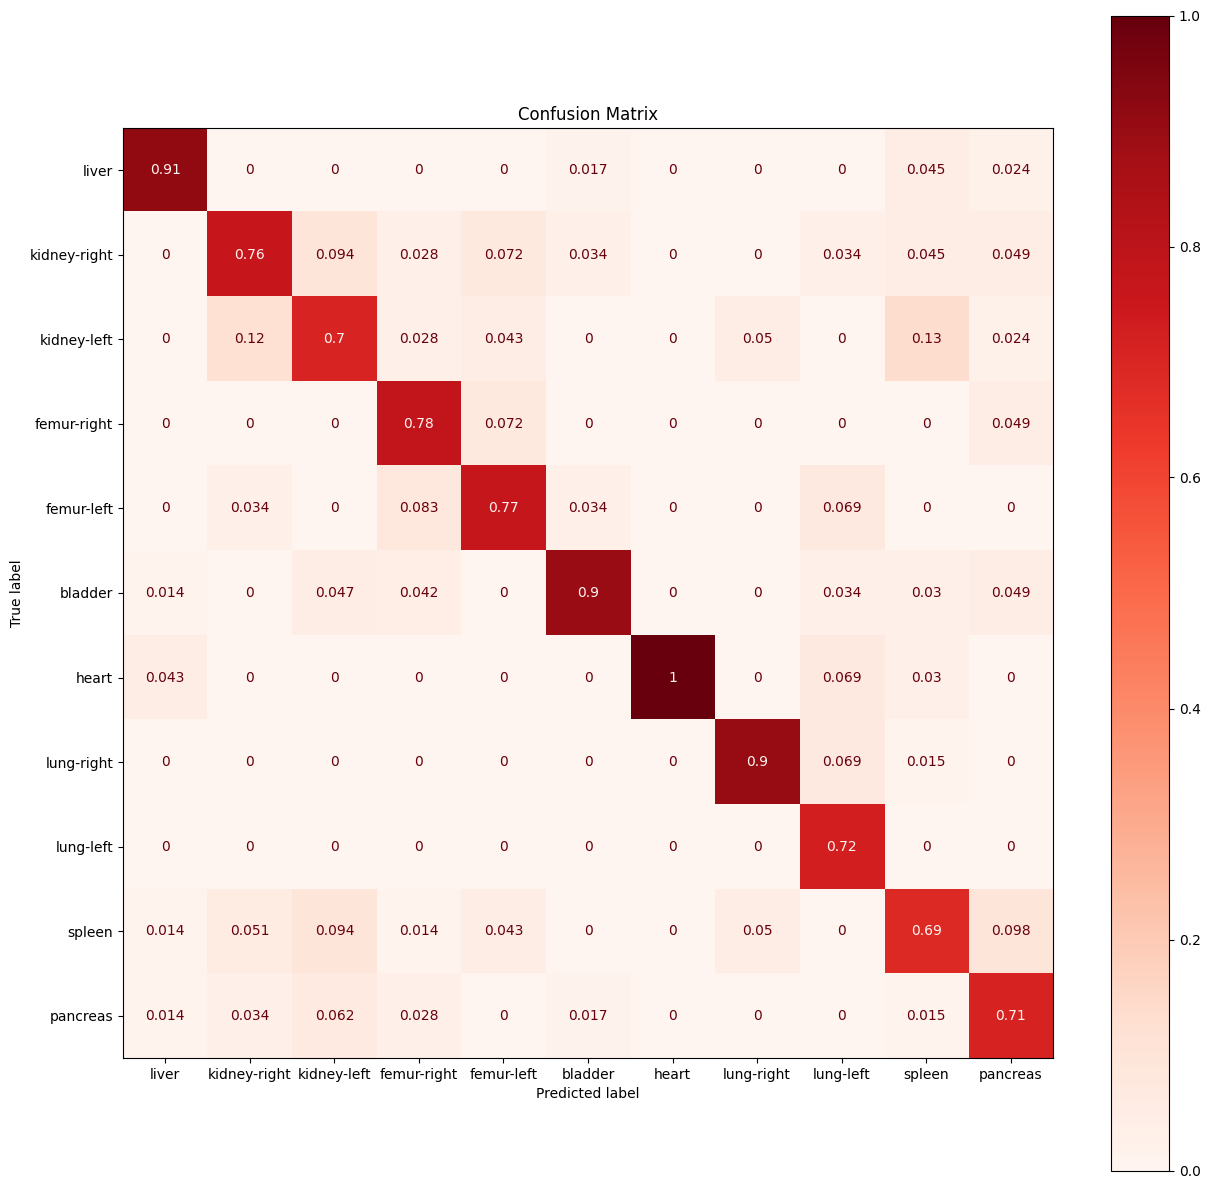

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');


print_cm(model)

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

In [57]:
for _ in tqdm(range(5)):
    X_augmented = np.concatenate((X_augmented, X_train), axis = 0)
    y_augmented = np.concatenate((y_augmented, y_train), axis = 0)
    s = pd.Series(y_augmented.argmax(axis = -1))
    while min(s.value_counts()) != max(s.value_counts()):
        aux = s[s==s.value_counts()[s.value_counts() == min(s.value_counts())].index[0]]
        idx = aux.index[random.randint(0, len(aux)-1)]
        x, y = augmentor(X_augmented[idx]), y_augmented[idx]
        X_augmented = np.concatenate((X_augmented, np.array([x])), axis = 0)
        y_augmented = np.concatenate((y_augmented, np.array([y])), axis = 0)
        s = pd.Series(y_augmented.argmax(axis = -1))
        print(min(s.value_counts()), end = "\r")

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:18<05:15, 78.79s/it]

 40%|████      | 2/5 [02:48<04:16, 85.38s/it]

 60%|██████    | 3/5 [04:30<03:05, 92.62s/it]

 80%|████████  | 4/5 [06:22<01:40, 100.35s/it]

100%|██████████| 5/5 [08:25<00:00, 101.12s/it]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/6
109/109 [==============================] - 40s 97ms/step - loss: 2.0757 - accuracy: 0.3076 - val_loss: 1.2591 - val_accuracy: 0.4783 - lr: 0.0010
Epoch 2/6
109/109 [==============================] - 6s 51ms/step - loss: 0.8877 - accuracy: 0.6636 - val_loss: 0.8443 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 3/6
109/109 [==============================] - 5s 50ms/step - loss: 0.4029 - accuracy: 0.8594 - val_loss: 0.3866 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 4/6
109/109 [==============================] - 6s 52ms/step - loss: 0.1730 - accuracy: 0.9447 - val_loss: 0.3376 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 5/6
109/109 [==============================] - 6s 51ms/step - loss: 0.0632 - accuracy: 0.9814 - val_loss: 0.3384 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 6/6
20/20 [==============================] - 5s 16ms/step
Loss: 1.264
Precisión: 70.33%


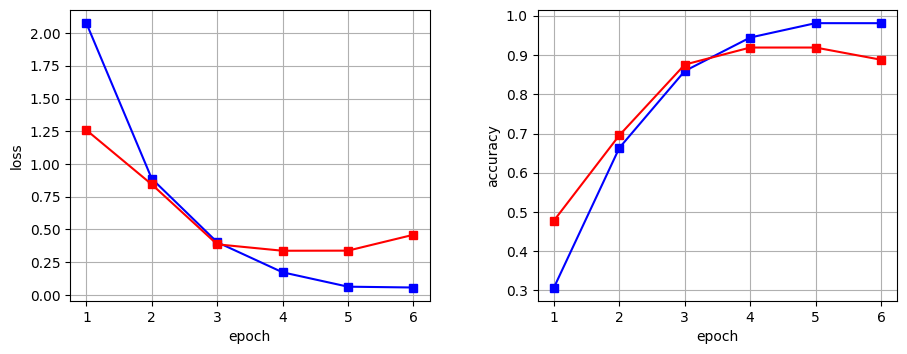

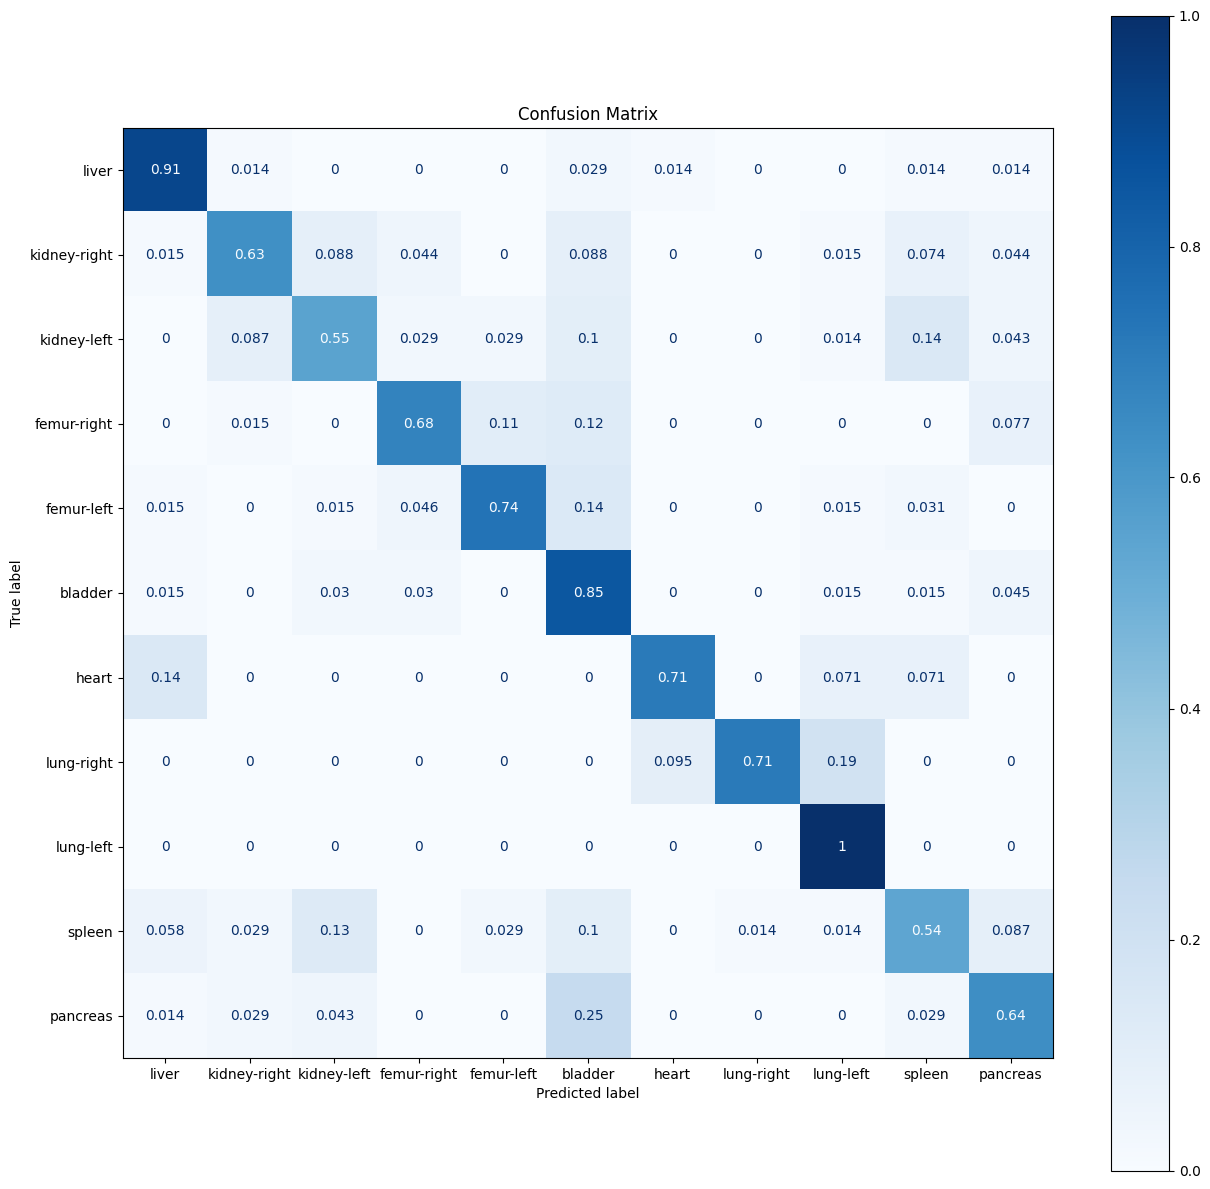

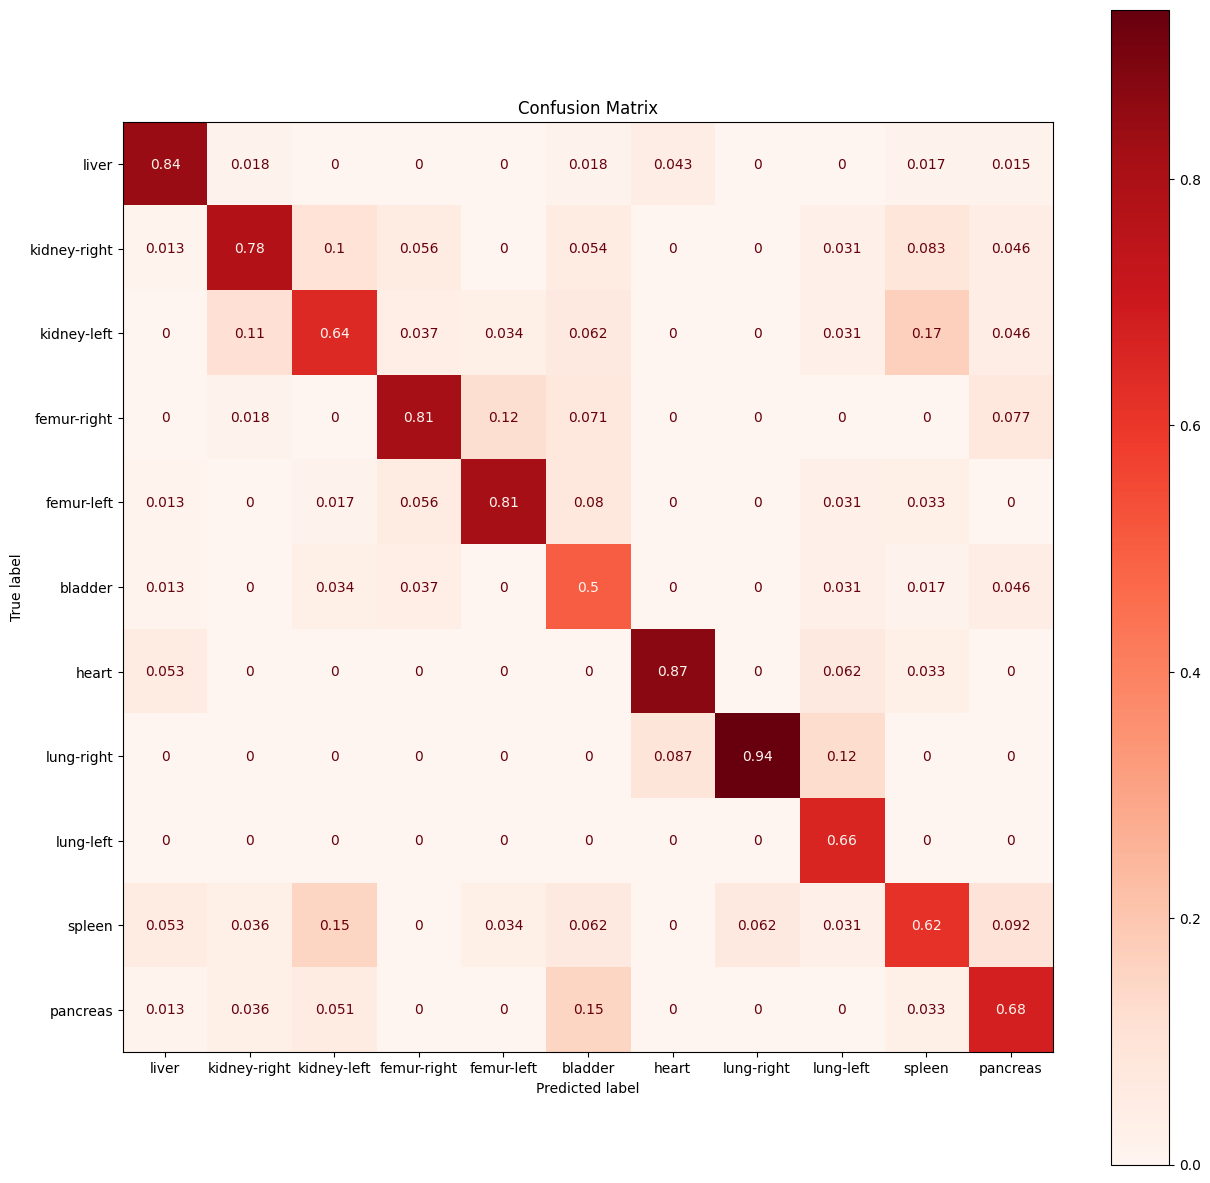

In [60]:
# Note: 'keras<3.x' or 'tf_keras' must be installed (legacy)
# See https://github.com/keras-team/tf-keras for more details.
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/video-vision-transformer")


from tensorflow.python.keras.callbacks import ReduceLROnPlateau

factor = 0.313359; patience = 10
kwargs = {}
reduce_cb = ReduceLROnPlateau(
        monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-7)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
kwargs['callbacks'] = [reduce_cb]


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
H = model.fit(X_augmented, y_augmented, batch_size=128, epochs=6, validation_data=(X_val, y_val), **kwargs)


fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');


print_cm(model)

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

# ViT

In [ ]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size = 64)
val_dataset = DataClass(split='val', download=download, size = 64)
test_dataset = DataClass(split='test', download=download, size = 64)

import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    
    
import numpy as np

x, y = train_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = np.expand_dims(x[0], axis=-1)
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
input_shape = X_train[0].shape
input_shape

In [19]:
import torch 
from torch import nn
import math


device = "cuda" if torch.cuda.is_available() else "cpu"

#training parameters
B = 128 #batch size
batch_size = B

#image parameters
C = 64
H = 64
W = 64
x = torch.rand(B, C, H, W)

#model parameters
D = 64 #hidden size
P = 8 #patch size
N = int(H*W/P**2) #number of tokens
k = 4 #number of attention heads
Dh = int(D/k) #attention head size
p = 0.1 #dropout rate
mlp_size = D*4
L = 4 #number of transformer blocks
n_classes = num_classes #number of classes

# Image Embeddings [Patch, Class, with Possition Embeddings]

class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()

        self.unfold = nn.Unfold(kernel_size = P, stride = P) #function to create patch vectors (x_p^i)
        self.project = nn.Linear(P**2*C, D) #patch tokens (E)
        self.cls_token = nn.Parameter(torch.randn((1, 1, D))) #function to create unbatched class token (x_class) as trainable parameter
        self.pos_embedding = nn.Parameter(torch.randn((1, N+1, D))) #function to create unbatched position embedding (E_pos) as trainable parameter
        self.dropout = nn.Dropout(p) 

        #Why unbatched? Because it allows to set parameters and functions here
        #Batched will increase parameter size without effectively improving it

    def forward(self, x, verbose = False): 
        #print("######")
        #print("input image:", x.shape)
        x = self.unfold(x).transpose(1, 2) #patch vectors (x_p^i)
        #print("x_p^i:", x.shape)
        #print(self.project.weight.dtype, x.dtype)
        x = self.project(x)
        #print("x_p^i*E:", x.shape) #tokens for patches (x_p^i*E)
        cls_token = self.cls_token.expand(x.size()[0], -1, -1) #batched class token (x_class)
        #print("x_class:", cls_token.shape)
        x = torch.cat((cls_token, x), dim = 1) #concatenate class, final image token embedding
        #print("patch embedding:", x.shape)
        pos_embedding = self.pos_embedding.expand(x.size()[0], -1, -1) #batched pos embedding (E_pos)
        #print("E_pos:", pos_embedding.shape)
        z0 = x + pos_embedding #adding both embeddings
        #print("z0:", z0.shape)
        z0 = self.dropout(z0) #dropout
        return z0



# Single Head Attention

class Single_Head_Attention(nn.Module):
    def __init__(self):
        super(Single_Head_Attention, self).__init__()

        self.U_qkv = nn.Linear(D, 3*Dh)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, z):
        #print("z:", z.shape)
        qkv = self.U_qkv(z)
        #print("qkv:", qkv.shape)
        q = qkv[:,:,:Dh]
        #print("q:", q.shape)
        k = qkv[:,:,Dh:2*Dh]
        #print("k:", k.shape)
        v = qkv[:,:,2*Dh:]
        #print("v:", v.shape)
        qkTbysqrtDh = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(Dh)
        #print("qkTbysqrtDh:", qkTbysqrtDh.shape)
        A = self.softmax(qkTbysqrtDh)
        #print("A:", A.shape)
        SAz = torch.matmul(A, v)
        #print("SAz:", SAz)

        return SAz
    
# Multi Head Self Attention

class Multi_Head_Self_Attention(nn.Module):
    def __init__(self):
        super(Multi_Head_Self_Attention, self).__init__()

        self.heads = nn.ModuleList([Single_Head_Attention() for _ in range(k)])
        self.U_msa = nn.Linear(D, D)
        self.dropout = nn.Dropout(p)

    def forward(self, z):
        ###print("#####")
        ###print("z:", z.shape)
        ConSAz = torch.cat([head(z) for head in self.heads], dim = -1)
        ###print("ConSA(z):", ConSAz.shape)
        msaz = self.U_msa(z)
        ###print("MSA(z):", msaz.shape)
        msaz = self.dropout(msaz)

        return msaz
    

# MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.U_mlp = nn.Linear(D, mlp_size)
        self.gelu = nn.GELU()
        self.U_mlp2 = nn.Linear(mlp_size, D)
        self.dropout = nn.Dropout(p)

    def forward(self, z):
        ##print("###MLP###")
        ##print("z:", z.shape)
        z = self.U_mlp(z)
        ##print("mlp(z):", z.shape)
        z = self.gelu(z)
        z = self.dropout(z)
        z = self.U_mlp2(z)
        ##print("mlp2(gelu(mlp(z))):", z.shape)
        z = self.gelu(z)
        z = self.dropout(z)

        return z
    

# Transformer Block

class Transformer_Block(nn.Module):
    def __init__(self):
        super(Transformer_Block, self).__init__()

        self.layernorm_1 = nn.LayerNorm(D)
        self.msa = Multi_Head_Self_Attention()
        self.layernorm_2 = nn.LayerNorm(D)
        self.mlp = MLP()

    def forward(self, z):
        #print("###Transformer Block###")
        #print("z:", z.shape)
        z1 = self.layernorm_1(z)
        #print("layernorm_1:", z1.shape)
        z1 = self.msa(z1)
        #print("msa(layernorm_1(z)):", z1.shape)
        z2 = z + z1
        #print("z + msa(layernorm_1(z)):", z2.shape)
        z3 = self.layernorm_2(z2)
        #print("layernorm_2(z + msa(layernorm_1(z))):", z3.shape)
        z3 = self.mlp(z3)
        #print("mlp(layernorm_2(z + msa(layernorm_1(z)))):", z3.shape)
        z4 = z2 + z3
        #print("z2 + mlp(layernorm_2(z + msa(layernorm_1(z)))):", z4.shape)

        return z4
    


# ViT

class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()

        self.embedding = Embedding()
        self.transformer_encoder = nn.ModuleList([Transformer_Block() for _ in range(L)])
        self.layernorm = nn.LayerNorm(D)
        self.U_mlp = nn.Linear(D, n_classes)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = torch.squeeze(x)
        x = x.to(torch.float32)
        #print(x.dtype)
        #print("###ViT###")
        #print("input image:", x.shape)
        z = self.embedding(x)
        #print("z:", z.shape)
        for block in self.transformer_encoder:
            z = block(z)
        #print("z:", z.shape)
        z = self.layernorm(z)
        #print("layernorm(z):", z.shape)
        z = z[:,0,:]
        #print("z:", z.shape)
        z = self.U_mlp(z)
        #print("mlp(layernorm(z)):", z.shape)
        z = self.softmax(z)
        

        return z

In [8]:
import torch.nn.functional as F


def get_batch(split):
    data = train_loader if split == "train" else val_loader
    x, y = next(iter(data))
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() #sets to evaluation phase, with our model it does nothing
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            logits = model(x)
            targets =  torch.squeeze(F.one_hot(y)).to(torch.float32)
            loss = F.cross_entropy(logits, targets)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() #sets to training phase, with our model it does nothing
    return out


In [11]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    acc = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        labels_onehot = torch.squeeze(F.one_hot(labels)).to(torch.float32)
        #print(outputs.size(), labels.size())
        #print(outputs.dtype, labels.dtype)
        
        loss = F.cross_entropy(outputs, labels_onehot)
        loss.backward()
        acc += (torch.argmax(outputs, dim = 1) == labels).sum().item()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 8 == 7:
            last_loss = running_loss / 8 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss, acc/X_train.shape[0]

In [14]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
m = ViT()
model = m.to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr = 0.01)

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, acc = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    vacc = 0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vlabels_onehot = torch.squeeze(F.one_hot(vlabels)).to(torch.float32)
            vloss = F.cross_entropy(voutputs, vlabels_onehot)
            running_vloss += vloss
            vacc += (torch.argmax(voutputs, dim = 1) == vlabels).sum().item()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}, accuracy {}, accuracy val {}'.format(avg_loss, avg_vloss, acc, vacc/X_val.shape[0]))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 8 loss: 2.39195254445076
LOSS train 2.39195254445076 valid 2.3961353302001953, accuracy 12.742533470648816, accuracy val 16.0
EPOCH 2:
  batch 8 loss: 2.3815618455410004
LOSS train 2.3815618455410004 valid 2.396305561065674, accuracy 14.932028836251288, accuracy val 16.0
EPOCH 3:
  batch 8 loss: 2.38090118765831
LOSS train 2.38090118765831 valid 2.3964591026306152, accuracy 14.549948506694129, accuracy val 16.0
EPOCH 4:
  batch 8 loss: 2.3768093585968018
LOSS train 2.3768093585968018 valid 2.3976550102233887, accuracy 14.57363542739444, accuracy val 16.0
EPOCH 5:
  batch 8 loss: 2.3823477625846863
LOSS train 2.3823477625846863 valid 2.39723801612854, accuracy 13.135942327497425, accuracy val 16.0
EPOCH 6:
  batch 8 loss: 2.381577879190445
LOSS train 2.381577879190445 valid 2.3986737728118896, accuracy 15.07415036045314, accuracy val 16.0
EPOCH 7:
  batch 8 loss: 2.37964329123497
LOSS train 2.37964329123497 valid 2.3991897106170654, accuracy 14.812564366632337, accuracy

In [34]:
print("Running on", device)
model = ViT()
m = model.to(device)
#TRAIN THE MODEL
optimizer = torch.optim.AdamW(m.parameters(), lr = 0.001)

max_iters = 200
eval_interval = 20
eval_iters = 10

for it in range(max_iters):
    if it % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {it}: train_loss {losses['train']:4f}, val_loss {losses['val']:4f}")
    xb, yb = get_batch("train")

    logits = m(xb)
    #targets =  torch.squeeze(F.one_hot(yb)).to(torch.float32)
    #print(logits.shape, torch.squeeze(yb).shape)
    loss = F.cross_entropy(logits, torch.squeeze(yb))
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()

print(loss.item())

Running on cuda
step 0: train_loss 2.394062, val_loss 2.397296
step 20: train_loss 2.379949, val_loss 2.401871
step 40: train_loss 2.375780, val_loss 2.396314
step 60: train_loss 2.379502, val_loss 2.397242
step 80: train_loss 2.376215, val_loss 2.397360
step 100: train_loss 2.372356, val_loss 2.396844
step 120: train_loss 2.378178, val_loss 2.396291
step 140: train_loss 2.376385, val_loss 2.396854
step 160: train_loss 2.380372, val_loss 2.399451
step 180: train_loss 2.374244, val_loss 2.396550
2.3851261138916016


In [20]:
from torch.optim import Adam
from tqdm import tqdm
#TRAINING LOOP
def train(model, train, val, learning_rate, epochs, batch_size=8, loss=nn.CrossEntropyLoss()):
    train_dataloader = train_loader
    val_dataloader = val_loader
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    optimizer = Adam(model.parameters(), lr= learning_rate)
    if use_cuda:
        model = model.cuda()
        criterion = loss.cuda()
    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            train_label = torch.squeeze(train_label).to(device)
            train_input = train_input.to(device)
            output = model(train_input)
            batch_loss = loss(output, train_label)
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        #validation on the development set
        total_acc_val = 0
        total_loss_val = 0
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = torch.squeeze(val_label).to(device)
                val_input = val_input.to(device)
                output = model(val_input)
                batch_loss = loss(output, val_label)
                total_loss_val += batch_loss.item()
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train): .3f} \ | Train Accuracy: {total_acc_train / len(train): .3f} \| Val Loss: {total_loss_val / len(val): .3f} \| Val Accuracy: {total_acc_val / len(val): .3f}')


In [21]:
from sklearn.metrics import f1_score
def evaluate(model, test, batch_size=8, evaltype=True):
    test_dataloader = test_loader
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()
    total_acc_test = 0
    predict=[]
    out = None
    with torch.no_grad():
        k=0
        for test_input, test_label in test_dataloader:
            test_label = torch.squeeze(test_label).to(device)
            test_input = test_input.to(device)
            output = model(test_input)
            if k == 0:
                out = output
            else:
                out = torch.cat((out, output), 0)
            k+=1
            if evaltype:
                acc = (output.argmax(dim=1) == test_label).sum().item()
                total_acc_test += acc
    if evaltype:
        print(f'Test Accuracy: {total_acc_test / len(out.argmax(dim=1)): .3f}')
    return out.argmax(dim=1)

In [22]:
#Hyperparameters
EPOCHS = 200
BATCH = 128
LR = 0.005
model = ViT()
#Fine-tuning the model
train(model, train_loader, val_loader, LR, EPOCHS, BATCH)
#Validating the model in the test dataset
preds = evaluate(model, test_loader, BATCH, True)

100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epochs: 1 | Train Loss:  2.385 \ | Train Accuracy:  28.500 \| Val Loss:  2.396 \| Val Accuracy:  15.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 2 | Train Loss:  2.381 \ | Train Accuracy:  28.750 \| Val Loss:  2.397 \| Val Accuracy:  13.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 3 | Train Loss:  2.377 \ | Train Accuracy:  30.000 \| Val Loss:  2.398 \| Val Accuracy:  15.000


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epochs: 4 | Train Loss:  2.379 \ | Train Accuracy:  28.000 \| Val Loss:  2.397 \| Val Accuracy:  19.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 5 | Train Loss:  2.377 \ | Train Accuracy:  26.000 \| Val Loss:  2.400 \| Val Accuracy:  13.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 6 | Train Loss:  2.377 \ | Train Accuracy:  28.750 \| Val Loss:  2.398 \| Val Accuracy:  14.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 7 | Train Loss:  2.377 \ | Train Accuracy:  27.750 \| Val Loss:  2.397 \| Val Accuracy:  16.000


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epochs: 8 | Train Loss:  2.376 \ | Train Accuracy:  27.250 \| Val Loss:  2.397 \| Val Accuracy:  16.000


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epochs: 9 | Train Loss:  2.375 \ | Train Accuracy:  27.250 \| Val Loss:  2.397 \| Val Accuracy:  13.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 10 | Train Loss:  2.376 \ | Train Accuracy:  29.750 \| Val Loss:  2.398 \| Val Accuracy:  15.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 11 | Train Loss:  2.377 \ | Train Accuracy:  27.750 \| Val Loss:  2.397 \| Val Accuracy:  15.000


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epochs: 12 | Train Loss:  2.378 \ | Train Accuracy:  24.750 \| Val Loss:  2.397 \| Val Accuracy:  18.000


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Epochs: 13 | Train Loss:  2.377 \ | Train Accuracy:  27.250 \| Val Loss:  2.397 \| Val Accuracy:  16.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 14 | Train Loss:  2.376 \ | Train Accuracy:  28.250 \| Val Loss:  2.398 \| Val Accuracy:  17.000


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epochs: 15 | Train Loss:  2.376 \ | Train Accuracy:  29.750 \| Val Loss:  2.395 \| Val Accuracy:  24.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 16 | Train Loss:  2.377 \ | Train Accuracy:  26.750 \| Val Loss:  2.398 \| Val Accuracy:  11.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 17 | Train Loss:  2.377 \ | Train Accuracy:  28.250 \| Val Loss:  2.397 \| Val Accuracy:  16.000


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Epochs: 18 | Train Loss:  2.376 \ | Train Accuracy:  26.250 \| Val Loss:  2.397 \| Val Accuracy:  15.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 19 | Train Loss:  2.376 \ | Train Accuracy:  28.500 \| Val Loss:  2.399 \| Val Accuracy:  10.000


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epochs: 20 | Train Loss:  2.377 \ | Train Accuracy:  28.000 \| Val Loss:  2.397 \| Val Accuracy:  18.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 21 | Train Loss:  2.376 \ | Train Accuracy:  26.250 \| Val Loss:  2.395 \| Val Accuracy:  22.000


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epochs: 22 | Train Loss:  2.376 \ | Train Accuracy:  28.000 \| Val Loss:  2.398 \| Val Accuracy:  15.000


  0%|          | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: 

## 2a implementación

In [12]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [13]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [14]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [15]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [16]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=11):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) 


In [17]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [18]:
BATCH_SIZE = 256
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [27]:

import torch.optim.lr_scheduler as lr_scheduler

abs
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = MyViT((64, 64, 64), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=11).to(device)
N_EPOCHS = 100
LR = 0.005

# Training loop
optimizer = Adam(model.parameters(), lr=LR)
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=100)
criterion = nn.CrossEntropyLoss()

last_loss = 100000
count = 0
model.train()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x, y = torch.squeeze(x).to(device), torch.squeeze(y).to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if last_loss <= train_loss: 
        count += 1
        if count == 3:
            count = 0
            #scheduler.step()
    last_loss = train_loss

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}, lr {optimizer.param_groups[0]['lr']}")

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = torch.squeeze(x).to(device), torch.squeeze(y).to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Using device:  cuda (Tesla T4)


Training:   1%|          | 1/100 [00:11<19:14, 11.66s/it]

Epoch 1/100 loss: 2.39, lr 0.005


Training:   2%|▏         | 2/100 [00:22<18:31, 11.35s/it]

Epoch 2/100 loss: 2.38, lr 0.005


Training:   3%|▎         | 3/100 [00:33<18:09, 11.24s/it]

Epoch 3/100 loss: 2.38, lr 0.005


Training:   4%|▍         | 4/100 [00:45<17:57, 11.23s/it]

Epoch 4/100 loss: 2.38, lr 0.005


Training:   5%|▌         | 5/100 [00:56<17:41, 11.18s/it]

Epoch 5/100 loss: 2.38, lr 0.005


Training:   6%|▌         | 6/100 [01:07<17:29, 11.17s/it]

Epoch 6/100 loss: 2.38, lr 0.005


Training:   7%|▋         | 7/100 [01:18<17:16, 11.15s/it]

Epoch 7/100 loss: 2.38, lr 0.005


Training:   8%|▊         | 8/100 [01:29<17:05, 11.15s/it]

Epoch 8/100 loss: 2.38, lr 0.005


Training:   9%|▉         | 9/100 [01:41<17:06, 11.28s/it]

Epoch 9/100 loss: 2.37, lr 0.005


Training:  10%|█         | 10/100 [01:52<16:50, 11.23s/it]

Epoch 10/100 loss: 2.37, lr 0.005


Training:  11%|█         | 11/100 [02:03<16:36, 11.20s/it]

Epoch 11/100 loss: 2.36, lr 0.005


Training:  12%|█▏        | 12/100 [02:14<16:28, 11.23s/it]

Epoch 12/100 loss: 2.35, lr 0.005


Training:  13%|█▎        | 13/100 [02:25<16:13, 11.19s/it]

Epoch 13/100 loss: 2.32, lr 0.005


Training:  14%|█▍        | 14/100 [02:36<16:00, 11.17s/it]

Epoch 14/100 loss: 2.30, lr 0.005


Training:  15%|█▌        | 15/100 [02:48<15:50, 11.19s/it]

Epoch 15/100 loss: 2.30, lr 0.005


Training:  16%|█▌        | 16/100 [02:59<15:37, 11.16s/it]

Epoch 16/100 loss: 2.29, lr 0.005


Training:  17%|█▋        | 17/100 [03:10<15:25, 11.16s/it]

Epoch 17/100 loss: 2.28, lr 0.005


Training:  18%|█▊        | 18/100 [03:21<15:15, 11.16s/it]

Epoch 18/100 loss: 2.27, lr 0.005


Training:  19%|█▉        | 19/100 [03:32<15:09, 11.23s/it]

Epoch 19/100 loss: 2.26, lr 0.005


Training:  20%|██        | 20/100 [03:44<15:00, 11.26s/it]

Epoch 20/100 loss: 2.25, lr 0.005


Training:  21%|██        | 21/100 [03:55<14:47, 11.24s/it]

Epoch 21/100 loss: 2.24, lr 0.005


Training:  22%|██▏       | 22/100 [04:06<14:36, 11.23s/it]

Epoch 22/100 loss: 2.24, lr 0.005


Training:  23%|██▎       | 23/100 [04:18<14:28, 11.28s/it]

Epoch 23/100 loss: 2.23, lr 0.005


Training:  24%|██▍       | 24/100 [04:29<14:14, 11.24s/it]

Epoch 24/100 loss: 2.23, lr 0.005


Training:  25%|██▌       | 25/100 [04:40<14:01, 11.21s/it]

Epoch 25/100 loss: 2.23, lr 0.005


Training:  26%|██▌       | 26/100 [04:51<13:50, 11.22s/it]

Epoch 26/100 loss: 2.22, lr 0.005


Training:  27%|██▋       | 27/100 [05:02<13:38, 11.21s/it]

Epoch 27/100 loss: 2.22, lr 0.005


Training:  28%|██▊       | 28/100 [05:14<13:26, 11.20s/it]

Epoch 28/100 loss: 2.23, lr 0.005


Training:  29%|██▉       | 29/100 [05:25<13:18, 11.25s/it]

Epoch 29/100 loss: 2.21, lr 0.005


Training:  30%|███       | 30/100 [05:36<13:04, 11.21s/it]

Epoch 30/100 loss: 2.21, lr 0.005


Training:  31%|███       | 31/100 [05:48<13:08, 11.43s/it]

Epoch 31/100 loss: 2.21, lr 0.005


Training:  32%|███▏      | 32/100 [05:59<12:53, 11.37s/it]

Epoch 32/100 loss: 2.20, lr 0.005


Training:  33%|███▎      | 33/100 [06:10<12:38, 11.32s/it]

Epoch 33/100 loss: 2.20, lr 0.005


Training:  34%|███▍      | 34/100 [06:22<12:25, 11.30s/it]

Epoch 34/100 loss: 2.19, lr 0.005


Training:  35%|███▌      | 35/100 [06:33<12:10, 11.25s/it]

Epoch 35/100 loss: 2.18, lr 0.005


Training:  36%|███▌      | 36/100 [06:44<11:58, 11.22s/it]

Epoch 36/100 loss: 2.18, lr 0.005


Training:  37%|███▋      | 37/100 [06:55<11:46, 11.22s/it]

Epoch 37/100 loss: 2.16, lr 0.005


Training:  38%|███▊      | 38/100 [07:06<11:33, 11.19s/it]

Epoch 38/100 loss: 2.15, lr 0.005


Training:  39%|███▉      | 39/100 [07:17<11:23, 11.20s/it]

Epoch 39/100 loss: 2.15, lr 0.005


Training:  40%|████      | 40/100 [07:29<11:15, 11.26s/it]

Epoch 40/100 loss: 2.14, lr 0.005


Training:  41%|████      | 41/100 [07:40<11:03, 11.25s/it]

Epoch 41/100 loss: 2.14, lr 0.005


Training:  42%|████▏     | 42/100 [07:51<10:53, 11.26s/it]

Epoch 42/100 loss: 2.16, lr 0.005


Training:  43%|████▎     | 43/100 [08:03<10:42, 11.28s/it]

Epoch 43/100 loss: 2.12, lr 0.005


Training:  44%|████▍     | 44/100 [08:14<10:29, 11.24s/it]

Epoch 44/100 loss: 2.12, lr 0.005


Training:  45%|████▌     | 45/100 [08:25<10:18, 11.25s/it]

Epoch 45/100 loss: 2.09, lr 0.005


Training:  46%|████▌     | 46/100 [08:36<10:06, 11.24s/it]

Epoch 46/100 loss: 2.07, lr 0.005


Training:  47%|████▋     | 47/100 [08:48<09:55, 11.24s/it]

Epoch 47/100 loss: 2.08, lr 0.005


Training:  48%|████▊     | 48/100 [08:59<09:45, 11.25s/it]

Epoch 48/100 loss: 2.07, lr 0.005


Training:  49%|████▉     | 49/100 [09:10<09:34, 11.26s/it]

Epoch 49/100 loss: 2.07, lr 0.005


Training:  50%|█████     | 50/100 [09:21<09:22, 11.25s/it]

Epoch 50/100 loss: 2.05, lr 0.005


Training:  51%|█████     | 51/100 [09:33<09:12, 11.27s/it]

Epoch 51/100 loss: 2.06, lr 0.005


Training:  52%|█████▏    | 52/100 [09:44<09:01, 11.29s/it]

Epoch 52/100 loss: 2.04, lr 0.005


Training:  53%|█████▎    | 53/100 [09:55<08:51, 11.32s/it]

Epoch 53/100 loss: 2.03, lr 0.005


Training:  54%|█████▍    | 54/100 [10:07<08:42, 11.36s/it]

Epoch 54/100 loss: 2.02, lr 0.005


Training:  55%|█████▌    | 55/100 [10:18<08:29, 11.33s/it]

Epoch 55/100 loss: 2.03, lr 0.005


Training:  56%|█████▌    | 56/100 [10:29<08:19, 11.35s/it]

Epoch 56/100 loss: 2.03, lr 0.005


Training:  57%|█████▋    | 57/100 [10:41<08:09, 11.38s/it]

Epoch 57/100 loss: 2.02, lr 0.005


Training:  58%|█████▊    | 58/100 [10:52<07:57, 11.37s/it]

Epoch 58/100 loss: 2.02, lr 0.005


Training:  59%|█████▉    | 59/100 [11:04<07:49, 11.46s/it]

Epoch 59/100 loss: 2.02, lr 0.005


Training:  60%|██████    | 60/100 [11:15<07:36, 11.40s/it]

Epoch 60/100 loss: 2.00, lr 0.005


Training:  61%|██████    | 61/100 [11:26<07:21, 11.32s/it]

Epoch 61/100 loss: 2.00, lr 0.005


Training:  62%|██████▏   | 62/100 [11:38<07:09, 11.30s/it]

Epoch 62/100 loss: 1.99, lr 0.005


Training:  63%|██████▎   | 63/100 [11:49<06:56, 11.26s/it]

Epoch 63/100 loss: 2.00, lr 0.005


Training:  64%|██████▍   | 64/100 [12:00<06:44, 11.23s/it]

Epoch 64/100 loss: 2.00, lr 0.005


Training:  65%|██████▌   | 65/100 [12:11<06:33, 11.25s/it]

Epoch 65/100 loss: 1.99, lr 0.005


Training:  66%|██████▌   | 66/100 [12:22<06:21, 11.21s/it]

Epoch 66/100 loss: 2.00, lr 0.005


Training:  67%|██████▋   | 67/100 [12:34<06:16, 11.41s/it]

Epoch 67/100 loss: 1.98, lr 0.005


Training:  68%|██████▊   | 68/100 [12:46<06:04, 11.39s/it]

Epoch 68/100 loss: 2.00, lr 0.005


Training:  69%|██████▉   | 69/100 [12:57<05:51, 11.33s/it]

Epoch 69/100 loss: 1.99, lr 0.005


Training:  70%|███████   | 70/100 [13:08<05:39, 11.33s/it]

Epoch 70/100 loss: 1.98, lr 0.005


Training:  71%|███████   | 71/100 [13:19<05:28, 11.33s/it]

Epoch 71/100 loss: 1.96, lr 0.005


Training:  72%|███████▏  | 72/100 [13:31<05:16, 11.30s/it]

Epoch 72/100 loss: 1.96, lr 0.005


Training:  73%|███████▎  | 73/100 [13:42<05:05, 11.32s/it]

Epoch 73/100 loss: 1.96, lr 0.005


Training:  74%|███████▍  | 74/100 [13:53<04:54, 11.32s/it]

Epoch 74/100 loss: 1.97, lr 0.005


Training:  75%|███████▌  | 75/100 [14:05<04:42, 11.31s/it]

Epoch 75/100 loss: 1.97, lr 0.005


Training:  76%|███████▌  | 76/100 [14:16<04:32, 11.35s/it]

Epoch 76/100 loss: 1.96, lr 0.005


Training:  77%|███████▋  | 77/100 [14:27<04:20, 11.35s/it]

Epoch 77/100 loss: 1.97, lr 0.005


Training:  78%|███████▊  | 78/100 [14:39<04:09, 11.34s/it]

Epoch 78/100 loss: 1.98, lr 0.005


Training:  79%|███████▉  | 79/100 [14:50<03:58, 11.35s/it]

Epoch 79/100 loss: 1.97, lr 0.005


Training:  80%|████████  | 80/100 [15:01<03:46, 11.33s/it]

Epoch 80/100 loss: 1.96, lr 0.005


Training:  81%|████████  | 81/100 [15:13<03:35, 11.35s/it]

Epoch 81/100 loss: 1.97, lr 0.005


Training:  82%|████████▏ | 82/100 [15:24<03:24, 11.33s/it]

Epoch 82/100 loss: 1.97, lr 0.005


Training:  83%|████████▎ | 83/100 [15:35<03:12, 11.31s/it]

Epoch 83/100 loss: 1.97, lr 0.005


Training:  84%|████████▍ | 84/100 [15:47<03:01, 11.34s/it]

Epoch 84/100 loss: 1.95, lr 0.005


Training:  85%|████████▌ | 85/100 [15:58<02:49, 11.32s/it]

Epoch 85/100 loss: 1.95, lr 0.005


Training:  86%|████████▌ | 86/100 [16:09<02:38, 11.34s/it]

Epoch 86/100 loss: 1.95, lr 0.005


Training:  87%|████████▋ | 87/100 [16:21<02:27, 11.33s/it]

Epoch 87/100 loss: 1.97, lr 0.005


Training:  88%|████████▊ | 88/100 [16:32<02:15, 11.29s/it]

Epoch 88/100 loss: 1.97, lr 0.005


Training:  89%|████████▉ | 89/100 [16:43<02:03, 11.26s/it]

Epoch 89/100 loss: 1.95, lr 0.005


Training:  90%|█████████ | 90/100 [16:54<01:52, 11.29s/it]

Epoch 90/100 loss: 1.95, lr 0.005


Training:  91%|█████████ | 91/100 [17:06<01:41, 11.28s/it]

Epoch 91/100 loss: 1.93, lr 0.005


Training:  92%|█████████▏| 92/100 [17:17<01:29, 11.23s/it]

Epoch 92/100 loss: 1.94, lr 0.005


Training:  93%|█████████▎| 93/100 [17:28<01:18, 11.26s/it]

Epoch 93/100 loss: 1.93, lr 0.005


Training:  94%|█████████▍| 94/100 [17:39<01:07, 11.28s/it]

Epoch 94/100 loss: 1.93, lr 0.005


Training:  95%|█████████▌| 95/100 [17:51<00:56, 11.31s/it]

Epoch 95/100 loss: 1.94, lr 0.005


Training:  96%|█████████▌| 96/100 [18:02<00:45, 11.25s/it]

Epoch 96/100 loss: 1.93, lr 0.005


Training:  97%|█████████▋| 97/100 [18:13<00:33, 11.27s/it]

Epoch 97/100 loss: 1.94, lr 0.005


Training:  98%|█████████▊| 98/100 [18:25<00:22, 11.49s/it]

Epoch 98/100 loss: 1.93, lr 0.005


Training:  99%|█████████▉| 99/100 [18:36<00:11, 11.41s/it]

Epoch 99/100 loss: 1.92, lr 0.005


Training: 100%|██████████| 100/100 [18:48<00:00, 11.28s/it]


Epoch 100/100 loss: 1.93, lr 0.005


Testing:   0%|          | 0/2 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 944.12 MiB is free. Process 3026 has 13.82 GiB memory in use. Of the allocated memory 16.86 MiB is allocated by PyTorch, and 33.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Con AdEMAMix 

In [19]:
"""
Adapted from: https://pytorch.org/docs/1.6.0/_modules/torch/optim/adam.html
"""
import math
import torch
from torch.optim import Optimizer


def linear_warmup_scheduler(step, alpha_end, alpha_start=0, warmup=1):
    if step < warmup:
        a = step / float(warmup)
        return (1.0-a) * alpha_start + a * alpha_end
    return alpha_end


def linear_hl_warmup_scheduler(step, beta_end, beta_start=0, warmup=1):

    def f(beta, eps=1e-8):
        return math.log(0.5)/math.log(beta+eps)-1

    def f_inv(t):
        return math.pow(0.5, 1/(t+1))

    if step < warmup:
        a = step / float(warmup)
        return f_inv((1.0-a) * f(beta_start) + a * f(beta_end))
    return beta_end


class AdEMAMix(Optimizer):
    r"""Implements the AdEMAMix algorithm.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999, 0.9999)) 
            corresponding to beta_1, beta_2, beta_3 in AdEMAMix
        alpha (float): AdEMAMix alpha coeficient mixing the slow and fast EMAs (default: 2)
        beta3_warmup (int, optional): number of warmup steps used to increase beta3 (default: None)
        alpha_warmup: (int, optional): number of warmup steps used to increase alpha (default: None)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay as in AdamW (default: 0)
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999, 0.9999), alpha=2.0, 
                 beta3_warmup=None, alpha_warmup=None,  eps=1e-8,
                 weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= alpha:
            raise ValueError("Invalid alpha value: {}".format(alpha))
        defaults = dict(lr=lr, betas=betas, eps=eps, alpha=alpha, beta3_warmup=beta3_warmup,
                        alpha_warmup=alpha_warmup, weight_decay=weight_decay)
        super(AdEMAMix, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdEMAMix, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            
            lr = group["lr"]
            lmbda = group["weight_decay"]
            eps = group["eps"]
            beta1, beta2, beta3_final = group["betas"]
            beta3_warmup = group["beta3_warmup"]
            alpha_final = group["alpha"]
            alpha_warmup = group["alpha_warmup"]
        
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('AdEMAMix does not support sparse gradients.')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    if beta1 != 0.0: # save memory in case beta1 is 0.0
                        state['exp_avg_fast'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    else: 
                        state['exp_avg_fast'] = None
                    state['exp_avg_slow'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg_fast, exp_avg_slow, exp_avg_sq = state['exp_avg_fast'], state['exp_avg_slow'], state['exp_avg_sq']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Compute the effective alpha and beta3 in case warmup is used 
                if alpha_warmup is not None:
                    alpha = linear_warmup_scheduler(state["step"], alpha_end=alpha_final, alpha_start=0, warmup=alpha_warmup)
                else:
                    alpha = alpha_final
                
                if beta3_warmup is not None:
                    beta3 = linear_hl_warmup_scheduler(state["step"], beta_end=beta3_final, beta_start=beta1, warmup=beta3_warmup)
                else:
                    beta3 = beta3_final

                # Decay the first and second moment running average coefficient
                if beta1 != 0.0:
                    exp_avg_fast.mul_(beta1).add_(grad, alpha=1 - beta1)
                else:
                    exp_avg_fast = grad
                exp_avg_slow.mul_(beta3).add_(grad, alpha=1 - beta3)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

                update = (exp_avg_fast.div(bias_correction1) + alpha * exp_avg_slow) / denom

                # decay
                update.add_(p, alpha=lmbda)

                p.add_(-lr * update)

        return loss

In [21]:

import torch.optim.lr_scheduler as lr_scheduler

abs
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = MyViT((64, 64, 64), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=11).to(device)
N_EPOCHS = 100
LR = 0.005

import torch

# AdEMAMix parameters
lr = 1e-3
betas = (0.9, 0.999, 0.9999)
alpha = 8.0
beta3_warmup = alpha_warmup = num_iterations = 256_000
weight_decay = 0.1


# create an AdEMAMix optimizer 
optimizer = AdEMAMix(params=model.parameters(), 
               lr=lr, 
               betas=betas, 
               alpha=alpha, 
               beta3_warmup=beta3_warmup, 
               alpha_warmup=alpha_warmup, 
               weight_decay=weight_decay)

#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=100)
criterion = nn.CrossEntropyLoss()

last_loss = 100000
count = 0
model.train()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x, y = torch.squeeze(x).to(device), torch.squeeze(y).to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if last_loss <= train_loss: 
        count += 1
        if count == 3:
            count = 0
            #scheduler.step()
    last_loss = train_loss

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}, lr {optimizer.param_groups[0]['lr']}")

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = torch.squeeze(x).to(device), torch.squeeze(y).to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Using device:  cuda (Tesla T4)


Training:   1%|          | 1/100 [00:12<19:48, 12.01s/it]

Epoch 1/100 loss: 2.39, lr 0.001


Training:   2%|▏         | 2/100 [00:23<19:22, 11.87s/it]

Epoch 2/100 loss: 2.39, lr 0.001


Training:   3%|▎         | 3/100 [00:35<19:00, 11.76s/it]

Epoch 3/100 loss: 2.39, lr 0.001


Training:   4%|▍         | 4/100 [00:47<18:46, 11.74s/it]

Epoch 4/100 loss: 2.39, lr 0.001


Training:   5%|▌         | 5/100 [00:59<18:51, 11.91s/it]

Epoch 5/100 loss: 2.38, lr 0.001


Training:   6%|▌         | 6/100 [01:11<18:32, 11.83s/it]

Epoch 6/100 loss: 2.38, lr 0.001


Training:   7%|▋         | 7/100 [01:22<18:18, 11.81s/it]

Epoch 7/100 loss: 2.38, lr 0.001


Training:   8%|▊         | 8/100 [01:34<18:08, 11.83s/it]

Epoch 8/100 loss: 2.38, lr 0.001


Training:   9%|▉         | 9/100 [01:46<17:56, 11.83s/it]

Epoch 9/100 loss: 2.38, lr 0.001


Training:  10%|█         | 10/100 [01:58<17:43, 11.82s/it]

Epoch 10/100 loss: 2.38, lr 0.001


Training:  11%|█         | 11/100 [02:09<17:26, 11.76s/it]

Epoch 11/100 loss: 2.37, lr 0.001


Training:  12%|█▏        | 12/100 [02:21<17:08, 11.69s/it]

Epoch 12/100 loss: 2.37, lr 0.001


Training:  13%|█▎        | 13/100 [02:33<16:58, 11.71s/it]

Epoch 13/100 loss: 2.37, lr 0.001


Training:  14%|█▍        | 14/100 [02:44<16:48, 11.72s/it]

Epoch 14/100 loss: 2.36, lr 0.001


Training:  15%|█▌        | 15/100 [02:56<16:36, 11.72s/it]

Epoch 15/100 loss: 2.35, lr 0.001


Training:  16%|█▌        | 16/100 [03:08<16:35, 11.85s/it]

Epoch 16/100 loss: 2.35, lr 0.001


Training:  17%|█▋        | 17/100 [03:20<16:23, 11.85s/it]

Epoch 17/100 loss: 2.34, lr 0.001


Training:  18%|█▊        | 18/100 [03:32<16:10, 11.84s/it]

Epoch 18/100 loss: 2.33, lr 0.001


Training:  19%|█▉        | 19/100 [03:44<15:58, 11.84s/it]

Epoch 19/100 loss: 2.33, lr 0.001


Training:  20%|██        | 20/100 [03:56<15:46, 11.83s/it]

Epoch 20/100 loss: 2.32, lr 0.001


Training:  21%|██        | 21/100 [04:07<15:32, 11.80s/it]

Epoch 21/100 loss: 2.31, lr 0.001


Training:  22%|██▏       | 22/100 [04:19<15:21, 11.81s/it]

Epoch 22/100 loss: 2.31, lr 0.001


Training:  23%|██▎       | 23/100 [04:31<15:17, 11.92s/it]

Epoch 23/100 loss: 2.30, lr 0.001


Training:  24%|██▍       | 24/100 [04:43<15:02, 11.88s/it]

Epoch 24/100 loss: 2.30, lr 0.001


Training:  25%|██▌       | 25/100 [04:55<14:47, 11.83s/it]

Epoch 25/100 loss: 2.30, lr 0.001


Training:  26%|██▌       | 26/100 [05:07<14:37, 11.86s/it]

Epoch 26/100 loss: 2.29, lr 0.001


Training:  27%|██▋       | 27/100 [05:19<14:28, 11.89s/it]

Epoch 27/100 loss: 2.27, lr 0.001


Training:  28%|██▊       | 28/100 [05:31<14:14, 11.87s/it]

Epoch 28/100 loss: 2.27, lr 0.001


Training:  29%|██▉       | 29/100 [05:42<14:03, 11.89s/it]

Epoch 29/100 loss: 2.27, lr 0.001


Training:  30%|███       | 30/100 [05:54<13:46, 11.81s/it]

Epoch 30/100 loss: 2.27, lr 0.001


Training:  31%|███       | 31/100 [06:06<13:38, 11.87s/it]

Epoch 31/100 loss: 2.26, lr 0.001


Training:  32%|███▏      | 32/100 [06:18<13:28, 11.89s/it]

Epoch 32/100 loss: 2.25, lr 0.001


Training:  33%|███▎      | 33/100 [06:30<13:13, 11.85s/it]

Epoch 33/100 loss: 2.24, lr 0.001


Training:  34%|███▍      | 34/100 [06:42<12:59, 11.81s/it]

Epoch 34/100 loss: 2.24, lr 0.001


Training:  35%|███▌      | 35/100 [06:53<12:48, 11.83s/it]

Epoch 35/100 loss: 2.23, lr 0.001


Training:  36%|███▌      | 36/100 [07:05<12:34, 11.79s/it]

Epoch 36/100 loss: 2.24, lr 0.001


Training:  37%|███▋      | 37/100 [07:17<12:23, 11.80s/it]

Epoch 37/100 loss: 2.22, lr 0.001


Training:  38%|███▊      | 38/100 [07:29<12:14, 11.84s/it]

Epoch 38/100 loss: 2.22, lr 0.001


Training:  39%|███▉      | 39/100 [07:41<11:58, 11.79s/it]

Epoch 39/100 loss: 2.22, lr 0.001


Training:  40%|████      | 40/100 [07:52<11:50, 11.83s/it]

Epoch 40/100 loss: 2.21, lr 0.001


Training:  41%|████      | 41/100 [08:04<11:36, 11.81s/it]

Epoch 41/100 loss: 2.20, lr 0.001


Training:  42%|████▏     | 42/100 [08:16<11:23, 11.78s/it]

Epoch 42/100 loss: 2.20, lr 0.001


Training:  43%|████▎     | 43/100 [08:28<11:11, 11.77s/it]

Epoch 43/100 loss: 2.19, lr 0.001


Training:  44%|████▍     | 44/100 [08:39<10:57, 11.75s/it]

Epoch 44/100 loss: 2.19, lr 0.001


Training:  45%|████▌     | 45/100 [08:51<10:48, 11.78s/it]

Epoch 45/100 loss: 2.18, lr 0.001


Training:  46%|████▌     | 46/100 [09:03<10:36, 11.79s/it]

Epoch 46/100 loss: 2.17, lr 0.001


Training:  47%|████▋     | 47/100 [09:15<10:22, 11.74s/it]

Epoch 47/100 loss: 2.16, lr 0.001


Training:  48%|████▊     | 48/100 [09:26<10:09, 11.71s/it]

Epoch 48/100 loss: 2.16, lr 0.001


Training:  49%|████▉     | 49/100 [09:38<09:53, 11.64s/it]

Epoch 49/100 loss: 2.15, lr 0.001


Training:  50%|█████     | 50/100 [09:49<09:40, 11.61s/it]

Epoch 50/100 loss: 2.15, lr 0.001


Training:  51%|█████     | 51/100 [10:01<09:30, 11.64s/it]

Epoch 51/100 loss: 2.14, lr 0.001


Training:  52%|█████▏    | 52/100 [10:13<09:18, 11.64s/it]

Epoch 52/100 loss: 2.15, lr 0.001


Training:  53%|█████▎    | 53/100 [10:24<09:09, 11.70s/it]

Epoch 53/100 loss: 2.13, lr 0.001


Training:  54%|█████▍    | 54/100 [10:36<08:59, 11.72s/it]

Epoch 54/100 loss: 2.13, lr 0.001


Training:  55%|█████▌    | 55/100 [10:48<08:50, 11.78s/it]

Epoch 55/100 loss: 2.12, lr 0.001


Training:  56%|█████▌    | 56/100 [11:00<08:40, 11.82s/it]

Epoch 56/100 loss: 2.11, lr 0.001


Training:  57%|█████▋    | 57/100 [11:12<08:26, 11.78s/it]

Epoch 57/100 loss: 2.11, lr 0.001


Training:  58%|█████▊    | 58/100 [11:24<08:14, 11.78s/it]

Epoch 58/100 loss: 2.13, lr 0.001


Training:  59%|█████▉    | 59/100 [11:36<08:04, 11.83s/it]

Epoch 59/100 loss: 2.10, lr 0.001


Training:  60%|██████    | 60/100 [11:47<07:50, 11.77s/it]

Epoch 60/100 loss: 2.09, lr 0.001


Training:  61%|██████    | 61/100 [11:59<07:37, 11.73s/it]

Epoch 61/100 loss: 2.11, lr 0.001


Training:  62%|██████▏   | 62/100 [12:10<07:24, 11.71s/it]

Epoch 62/100 loss: 2.08, lr 0.001


Training:  63%|██████▎   | 63/100 [12:22<07:13, 11.70s/it]

Epoch 63/100 loss: 2.08, lr 0.001


Training:  64%|██████▍   | 64/100 [12:34<07:00, 11.68s/it]

Epoch 64/100 loss: 2.07, lr 0.001


Training:  65%|██████▌   | 65/100 [12:46<06:49, 11.71s/it]

Epoch 65/100 loss: 2.08, lr 0.001


Training:  66%|██████▌   | 66/100 [12:57<06:38, 11.72s/it]

Epoch 66/100 loss: 2.08, lr 0.001


Training:  67%|██████▋   | 67/100 [13:09<06:26, 11.71s/it]

Epoch 67/100 loss: 2.07, lr 0.001


Training:  68%|██████▊   | 68/100 [13:21<06:14, 11.69s/it]

Epoch 68/100 loss: 2.07, lr 0.001


Training:  69%|██████▉   | 69/100 [13:32<06:03, 11.74s/it]

Epoch 69/100 loss: 2.07, lr 0.001


Training:  70%|███████   | 70/100 [13:44<05:53, 11.77s/it]

Epoch 70/100 loss: 2.06, lr 0.001


Training:  71%|███████   | 71/100 [13:56<05:39, 11.70s/it]

Epoch 71/100 loss: 2.07, lr 0.001


Training:  72%|███████▏  | 72/100 [14:07<05:26, 11.68s/it]

Epoch 72/100 loss: 2.09, lr 0.001


Training:  73%|███████▎  | 73/100 [14:19<05:13, 11.63s/it]

Epoch 73/100 loss: 2.07, lr 0.001


Training:  74%|███████▍  | 74/100 [14:31<05:01, 11.60s/it]

Epoch 74/100 loss: 2.07, lr 0.001


Training:  75%|███████▌  | 75/100 [14:42<04:49, 11.58s/it]

Epoch 75/100 loss: 2.06, lr 0.001


Training:  76%|███████▌  | 76/100 [14:54<04:37, 11.54s/it]

Epoch 76/100 loss: 2.05, lr 0.001


Training:  77%|███████▋  | 77/100 [15:05<04:25, 11.53s/it]

Epoch 77/100 loss: 2.04, lr 0.001


Training:  78%|███████▊  | 78/100 [15:17<04:14, 11.56s/it]

Epoch 78/100 loss: 2.04, lr 0.001


Training:  79%|███████▉  | 79/100 [15:28<04:01, 11.51s/it]

Epoch 79/100 loss: 2.04, lr 0.001


Training:  80%|████████  | 80/100 [15:40<03:49, 11.50s/it]

Epoch 80/100 loss: 2.04, lr 0.001


Training:  81%|████████  | 81/100 [15:51<03:38, 11.52s/it]

Epoch 81/100 loss: 2.04, lr 0.001


Training:  82%|████████▏ | 82/100 [16:03<03:27, 11.54s/it]

Epoch 82/100 loss: 2.05, lr 0.001


Training:  83%|████████▎ | 83/100 [16:14<03:16, 11.57s/it]

Epoch 83/100 loss: 2.03, lr 0.001


Training:  84%|████████▍ | 84/100 [16:26<03:05, 11.61s/it]

Epoch 84/100 loss: 2.03, lr 0.001


Training:  85%|████████▌ | 85/100 [16:38<02:54, 11.63s/it]

Epoch 85/100 loss: 2.03, lr 0.001


Training:  86%|████████▌ | 86/100 [16:49<02:42, 11.59s/it]

Epoch 86/100 loss: 2.03, lr 0.001


Training:  87%|████████▋ | 87/100 [17:01<02:29, 11.54s/it]

Epoch 87/100 loss: 2.04, lr 0.001


Training:  88%|████████▊ | 88/100 [17:12<02:19, 11.63s/it]

Epoch 88/100 loss: 2.05, lr 0.001


Training:  89%|████████▉ | 89/100 [17:24<02:07, 11.62s/it]

Epoch 89/100 loss: 2.04, lr 0.001


Training:  90%|█████████ | 90/100 [17:36<01:56, 11.62s/it]

Epoch 90/100 loss: 2.07, lr 0.001


Training:  91%|█████████ | 91/100 [17:47<01:44, 11.60s/it]

Epoch 91/100 loss: 2.04, lr 0.001


Training:  92%|█████████▏| 92/100 [17:59<01:32, 11.57s/it]

Epoch 92/100 loss: 2.07, lr 0.001


Training:  93%|█████████▎| 93/100 [18:10<01:21, 11.57s/it]

Epoch 93/100 loss: 2.05, lr 0.001


Training:  94%|█████████▍| 94/100 [18:22<01:09, 11.63s/it]

Epoch 94/100 loss: 2.03, lr 0.001


Training:  95%|█████████▌| 95/100 [18:34<00:58, 11.61s/it]

Epoch 95/100 loss: 2.03, lr 0.001


Training:  96%|█████████▌| 96/100 [18:45<00:46, 11.57s/it]

Epoch 96/100 loss: 2.03, lr 0.001


Training:  97%|█████████▋| 97/100 [18:57<00:34, 11.59s/it]

Epoch 97/100 loss: 2.03, lr 0.001


Training:  98%|█████████▊| 98/100 [19:08<00:23, 11.59s/it]

Epoch 98/100 loss: 2.02, lr 0.001


Training:  99%|█████████▉| 99/100 [19:20<00:11, 11.56s/it]

Epoch 99/100 loss: 2.02, lr 0.001


Training: 100%|██████████| 100/100 [19:31<00:00, 11.72s/it]


Epoch 100/100 loss: 2.02, lr 0.001


Testing: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]

Test loss: 2.07
Test accuracy: 45.90%
